INTRODUCTION

We noticed that collaboration in the music industry is getting trendy from 10%-20% around 3 decades ago to approaching 30%+ of the top charts nowadays. It motivates us to create a “Collab Index/Score” dashboard concept to see how the artist is hot for collab success and how the audio features could be successful based on this collab in our project Part 1. We are going to generate the recommendation for collab success in audio features details and more in Part 2 with LLM leverage. Overall the application would be for the users to apply our collab model and index success with more customized feedback to brainstorm their music collab potential. The dataset to help model training is the Billboard 200 song Spotify audio features and Billboard 100 Chart dataset.


METHODS SELECTION

Part 1 is trained by ensembles among supervised models like neural networks and RF/DT tree-based models to generate the Collab Index in a simple or advanced version.

Part 2 is leveraging LangChain to deal with multiple LLMs in a generation of the recommendation. It could be facilitated by Streamlit for a better application presentation at the end.

RESULTS

Part 1 currently runs well. Our Simple and Advanced Index could tell appealing stories while some polishing under corner conditions. The current prediction treats data leakage prevention carefully (using 2010-2014 to predict 2015), and we still can get 95-98% accuracy by NN to confirm if the song would be listed in BB Hot 100.

Within Part 2 two goals: 1) Recommendation and Question Answering from trained data and .2) Generating chorus lyrics based on artist recommendations. We see the data to recommend collaborative artists to users, leveraging LangChain's retrieval-augmented generation to ensure relevance and accuracy. The second half is under way and it may explore generating tailored lyrics for these artist pairings.

DISCUSSION

Our Analysis could offer a lot of intriguing applications with nuance:

1) Collaboration becomes a great tool for artists to explore their uncharted success. We could show the strategy and logic behind it.

2) We could take the audio features to predict the success of BB100 or not, aiming for industry references.

3) We could inspire any new artists to simulate their success of collaborating with certain styles of the artists for them to approach popularity with better tools.

4) We could offer generative AI’s step into the music creation process with nuance and the possibility for further exploration of the whole process to connect the audio features, and title/hook to the success of the collaboration.

PART I - Music Collab Index and Neural Network Model

0 - LIBRARIES, DEPENDENCIES & OVERVIEW

1 - EDA & DATA PROCESSING

2 - TEXT AND VISUAL OUTPUT

3 - MODELLING AND PERFORMANCE



0 - LIBRARIES, DEPENDENCIES & OVERVIEW

In [ ]:
pip install requests

In [ ]:
pip install billboard.py

In [ ]:
pip install spotipy

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import base64
from datetime import datetime, timedelta
import billboard
import matplotlib.colors as mcolors
import math
from math import pi

# 1 - EDA & DATA PROCESSING

## 1.1 - LOAD EXISITING DATA

acoustic.csv - BB200 data with acoustic features

album_231201.csv - BB200 data up to date 2023-12-02 (tailored-made by our project)

charts_231201.csv - BB200 data up to date 2023-12-02 (tailored-made by our project)

album.csv - BB200 data between 1963-01-05 and 2019-01-19 (from source)

charts.csv - BB100 data 1958-08-04 and 2021-11-13 (from source)




In [ ]:
df_ac = pd.read_csv('./data/acoustic.csv')
# df_al = pd.read_csv('/content/album.csv')
# # df_ch = pd.read_csv('/content/charts.csv')

In [ ]:
df_al_231202 = pd.read_csv('./data/album_231202.csv')
df_ch_231202 = pd.read_csv('./data/charts_231202.csv')

In [ ]:
# make the file to csv"
def get_csv(filename, df):
  # Define the filename for the CSV file
  csv_filename = f'{filename}.csv'

  # Save the DataFrame to a CSV file
  df.to_csv(csv_filename, index=False)
  return

## 1.2 LOAD DATA FROM API

In [ ]:
# app credentials
CLIENT_ID = ''
CLIENT_SECRET = ''

# Base64 encode the credentials
credentials = base64.b64encode(f"{CLIENT_ID}:{CLIENT_SECRET}".encode()).decode()

# Request token
headers = {
    "Authorization": f"Basic {credentials}"
}
data = {
    "grant_type": "client_credentials"
}
response = requests.post("https://accounts.spotify.com/api/token", headers=headers, data=data)

# Check response
if response.status_code == 200:
    token = response.json()["access_token"]
    print(f"Token: {token}")
else:
    print(f"Failed to get token. Status code: {response.status_code}, Message: {response.text}")

### 1.2.1 Billboard Hot-100 Data Up-to-date

In [ ]:
def df_BB100_after(year, month, day):
  # Define the start and end dates for the chart data
  start_date = datetime(year, month, day) # start from the week with ending date with
  end_date = datetime.now()

  # Initialize an empty list to store all chart data
  all_chart_data = []

  # Loop through each week from start_date to end_date
  current_date = start_date
  while current_date <= end_date:
      try:
          # Fetch the Billboard chart data for the current week
          chart = billboard.ChartData('hot-100', date=current_date.strftime('%Y-%m-%d'))

          # Extract and store the chart data
          for song in chart:
              all_chart_data.append([current_date.strftime('%Y-%m-%d'), song.rank, song.title, song.artist])

          # Move to the next week
          current_date += timedelta(days=7)
      except Exception as e:
          # Handle exceptions (e.g., network issues, API limits)
          print(f"Error fetching data for {current_date}: {e}")
          # Optional: break the loop if too many errors occur
          break

  # Create a DataFrame with all the accumulated chart data
  df = pd.DataFrame(all_chart_data, columns=['date', 'rank', 'song', 'artist'])
    # Check if the DataFrame is empty
  if df.empty:
      # Handle the case for an empty DataFrame
      print("No data fetched.")
      # You can return an empty DataFrame, None, or handle it in another way
  return df  # or return None

In [ ]:
# for updated additional data if needed to merge after 12/02/2023
df_BB100_after = df_BB100_after(year=2023, month=12, day=2)
df_BB100_after

,date,rank,song,artist
0,2023-12-02,1,Lovin On Me,Jack Harlow
1,2023-12-02,2,Cruel Summer,Taylor Swift
2,2023-12-02,3,Paint The Town Red,Doja Cat
3,2023-12-02,4,All I Want For Christmas Is You,Mariah Carey
4,2023-12-02,5,Snooze,SZA
...,...,...,...,...
195,2023-12-09,96,But I Got A Beer In My Hand,Luke Bryan
196,2023-12-09,97,Labios Mordidos,Kali Uchis & Karol G
197,2023-12-09,98,Slut! (Taylor's Version) [From The Vault],Taylor Swift
198,2023-12-09,99,Rich Men North Of Richmond,Oliver Anthony Music


### 1.2.2 Billboard Album 200 Data Up-to-date

In [ ]:
from datetime import datetime, timedelta

def get_BB200_chart_data(year, month, day):
    # Start date for fetching data
    start_date = datetime(year, month, day)
    end_date = datetime.now()  # End at current date

    all_chart_data = []  # List to store all chart data

    current_date = start_date
    while current_date <= end_date:
        try:
            # Fetch the Billboard 200 chart for the current week
            chart = billboard.ChartData('billboard-200', date=current_date.strftime('%Y-%m-%d'))

            # Extract and store the chart data
            for album in chart:
                all_chart_data.append({
                    'date': current_date.strftime('%Y-%m-%d'),
                    'rank': album.rank,
                    'artist': album.artist,
                    'album': album.title,
                })

            # Move to the next week
            current_date += timedelta(days=7)
        except Exception as e:
            print(f"Error fetching data for {current_date}: {e}")
            break

    # Convert the list of dictionaries into a DataFrame
    df = pd.DataFrame(all_chart_data)
    if df.empty:
        print("No data fetched.")
        return None
    return df

In [ ]:
# for updated additional data if needed to merge after 12/02/2023
# df_BB200_after = get_BB200_chart_data(year=2023, month=12, day=2)
# df_BB200_after

In [ ]:
def get_csv(filename, df):
  # Define the filename for the CSV file
  csv_filename = 'filename.csv'

  # Save the DataFrame to a CSV file
  df.to_csv(csv_filename, index=False)
  return

## 1.2 - EDA

### 1.2.0 Functions

1.2.0.1 Check Missing Data

In [ ]:
# Check for missing values (optional)
def missing_check(df):
  # Check for missing values
  # Percentage of missing values for each column
  missing_percentage = (df.isnull().sum() / len(df)) * 100

  # Rows where at least one element is missing
  missing_rows = df[df.isnull().any(axis=1)]

  return (missing_percentage,
          missing_rows.head(20),
          missing_rows.tail(20),
          missing_rows.sample(min(len(missing_rows), 20)))


1.2.0.2 Fill Missing Data

In [ ]:
# fill up missing values (optional)
def missing_fill(df):
  # Fill missing values in numerical columns with the mean
  for column in df.select_dtypes(include=[np.number]).columns:
      df[column].fillna(df[column].mean(), inplace=True)

  # Fill missing values in categorical columns with the mode
  for column in df.select_dtypes(include=['object']).columns:
      mode_val = df[column].mode()[0]
      df[column].fillna(mode_val, inplace=True)
  return df

### 1.2.1 Dataset

1.2.1.1 Acoustic.csv

 Around 340K (339,850) rows containing acoustic data for tracks from Billboard 200 albums from 1963 to 1/19/2019. Each row contains 19 columns including 1) id - track ID on Spotify, 2) song - track name, 3) album - album name, 4) artist - artist name, 5) 13 values for Spotify EchoNest acoustic data a) acousticsness, b) danceability, c) duration_ms, d) energy, e)  instrumentalness, f) key, g) liveness,h) loudness, i) speechiness, j) mode, k) speechiness, l) tempo, m) time signature, and n) valence, 18) album_id - album ID on Spotify, and 19) date - release date of the album. This table is titled “acoustic.csv”.

In [ ]:
# df_ac.columns

In [ ]:
# df_ac.head(5).T

In [ ]:
# df_ac.tail(5).T

340K dataset, 19 columns, 6.5M data entries

object - id (song), song, album, artist, album_id, date

float64 - 13 audio features: 'acousticness', 'danceability',
       'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence'

date column starts from 1963 and ends at 2018-12-21, totally 55 years, but starting from year ends with YYYY-MM-DD


Total 25K albums, around 13-14 songs per album.



In [ ]:
# check acoustic csv
# missing_check(df_ac)[0]

missing artist, maybe like soundtrack or collections < 0.02%

In [ ]:
# missing_check(df_ac)[1].T

In [ ]:
# missing_check(df_ac)[2].T

In [ ]:
# missing_check(df_ac)[3].T

DECISION

- remove rows with missing artist since non-related with analysis

In [ ]:
# df_ac_new = df_ac.dropna()
# acoustic csv missing data done!

In [ ]:
# df_ac_new.describe().T

1.2.1.2 album.csv & album_231202.csv

574K around(573,947) rows containing all albums in the Billboard 200 from 1/5/1963 to 1/19/2019 - say 56 years. (However, it was the top 150 albums starting from 1963, then around the top 200 albums from 1967 to 2019- we have 2,705 data, which is around 52 years) Each row contains the 7 columns: 1) id - album_id in spotify, 2) date - chart date, 3) artist - the artist name of this album, 4) album - album name, 5) rank- album’s place in the charts, 6) length - length of the album which means how many songs ( in average it’s around 11 songs), 6) track_length - length of the track in milliseconds (60K milliseconds = 1 min, in average it’s around 3-4 minutes). This dataset is titled “album.csv”.


624K around(624,746) rows containing all albums in the Billboard 200 from 1/5/1963 to 12/02/2023 - say 60 years. (However, it was the top 150 albums starting from 1963, then around the top 200 albums from 1967 to 2023 around 56 years) Each row contains the 7 columns: 1)date - chart date, 2) rank- album’s place in the charts 3) artist - the artist name of this album, 4) album - album name.

There are totally 10K(10,169) around unique artists.
There are totally 35K(35,119) around unique albums.

This dataset is titled “album_231202.csv”.

In [ ]:
# df_al_231202.info()

Some obvious missing in the length and track_length data

In [ ]:
# # Convert 'date' to datetime format for proper sorting
# df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

# # Sort the DataFrame first by 'date' and then by 'rank' in ascending order
# df = df.sort_values(by=['date', 'rank'], ascending=[True, True])
# # starting from 2019-01-09

In [ ]:
# df_al

In [ ]:
# unique artist name
# len(df_al_231202.artist.unique())
# 10K around unique artist

In [ ]:
# len(set(df_al_231202.artist))

In [ ]:
# df_al.tail(5).T

In [ ]:
# # check album csv
# missing_check(df_al_231202)[0]
# # missing artist, maybe like soundtrack or collections 1.5%
# # decesion - remove missing artist since non-related with analysis

In [ ]:
# missing_check(df_al_231202)[1]

In [ ]:
# # Indices of the rows you want to modify (replace these with the actual indices)
# indices_to_modify = [304587, 304773, 304972, 305199, 305383, 305586, 305778, 305966, 306149]  # Example indices

# # Column you want to modify
# column_name = 'artist'  # Replace with the actual column name

# # Assign "Kenny G" to the specified rows in the specified column
# df_al_231202.loc[indices_to_modify, column_name] = "Kenny G"

In [ ]:
# missing_check(df_al_231202)[1]

## MISSINDG DATA TREATMENT

In [ ]:
# missing data processed completely
def album_process(df):
  df.loc[df['album'] == 'Silhouette', 'artist'] = 'Kenny G'
  df = df[df['album'] != 'Roots Of Country Music (1965)']
  df['date'] = pd.to_datetime(df['date'])

  # Filter the DataFrame for dates after 1973-01-01
  df = df[df['date'] > pd.Timestamp('1973-01-01')]
  return df
df_al_processed = album_process(df = df_al_231202)

<ipython-input-431-1274e561f7ac>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'])


## SLIDING DATA TREATMENT

In [ ]:
def chart_process(df):
  df = df[['date', 'rank', 'artist', 'song']]
  df['date'] = pd.to_datetime(df['date'])

  # Filter the DataFrame for dates after 1973-01-01
  df = df[df['date'] > pd.Timestamp('1973-01-01')]
  return df
df_ch_processed = chart_process(df = df_ch_231202)

In [ ]:
# missing_check(df_al_231202)[0]

In [ ]:
# df_al_new = df_al[['date', 'rank', 'artist', 'album']]
# df_al_new['rank'] = df_al_new['rank'].fillna(0).astype(int)
# df_al_new = df_al_new.drop(df_al_new.index[0])
# df_al_new

DECISION

- remove two columns (length and track_length) which are not related to our analysis

In [ ]:
# df_al_new.describe()

If reflects the observation that early years with top 150

In [ ]:
# df_al['rank'].iloc[-160:-140]
# it was 150 in the beginning!

In [ ]:
# df_al_rank = pd.DataFrame(df_al_new['rank'].value_counts()).reset_index()

# df_al_rank.columns = ['rank', 'count']
# df_al_rank
# df_al_rank[df_al_rank['rank'] == 151.0]
# there are 2705 weeks which has more than album 151

In [ ]:
# 2705/52
# it's around 52 years with album 200

In [ ]:
# df_al_rank['rank'] = df_al_rank['rank'].astype(int)
# df_al_rank_sorted = df_al_rank.sort_values(by ='rank')
# df_al_rank_sorted[140:159]
# around 2929-2705 = 224 weeks = 4 year with Album 150
# 1963 + 4 around 1967 to start Album 200

In [ ]:
# def plot_ave_length_per_album(df):
#   length = df_al.length.value_counts()
#   df_l = pd.DataFrame(length).reset_index()
#   df_l.columns = ['length', 'count']
#   df_l.filtered = df_l[df_l['length']< 50]
#   plt.bar(df_l.filtered['length'], df_l.filtered['count'])
#   plt.show()
# plot_ave_length_per_album(df = df_al)
# df_l.filtered
# 9-15 songs in one album are the majority

In [ ]:
# (574000/52)/195
# every week 200, every 52 weeks in a year, so around 56.6 years
# not related to aver. songs in album

In [ ]:
# df_al.artist.value_counts()


In [ ]:
# df_al.artist.value_counts()[:10]

This results echos our read from billboard recently about the top weeks occupied in BB chart for BB200 (including duplicate albums)

In [ ]:
# len(df_al_231202.album.unique())
#33K unique albums

1.2.1.3 chart.csv

Around 330K (330,087) rows containing chart data for tracks from Billboard 100 singles from 8/4/1958 to 11/16/2021. It’s a total of 63 years. Each row contains 8 columns including 1) date - date of the chart on BB100, 2) rank - the place of the single on the chart, 3) song - song name, 4) artist - artist name, 5) last-week - the place of last week, 6) peak-rank - the latest peak rank for the specific song 7) weeks-on-board - the accumulated week on the chart date, there are total 2.6M data points. This table is titled “chart.csv”.

Around 341K (340,887) rows containing chart data for tracks from Billboard 100 singles from 8/4/1958 to 12/02/2023. It’s a total of 64.5 years. Each row contains 8 columns including 1) date - date of the chart on BB100, 2) rank - the place of the single on the chart, 3) song - song name, and 4) artist - artist name. There are a total of 26K(25,704)songs. There are a total of 11K(10,720)artist combinations(including solo & collaboration). There are a total of 2.6M data points. This table is titled “chart_231201.csv”.

In [ ]:
# df_ch_231202.info()

Some missing in last-week, but limited impact

In [ ]:
# df_ch.head()

In [ ]:
# df_ch.columns

In [ ]:
# df_ch.tail()

In [ ]:
# df_ch[df_ch['song'] == 'Fancy Like']

It's confirmed the peak-rank is the latest peak rank according to the specific week, not back-award modified.

In [ ]:
# missing_check(df_ch_231202)[0]

In [ ]:
# len(df_ch_231202.artist.unique())

In [ ]:
# lst_artist = df_al.artist.unique()


In [ ]:
# df_al.artist.value_counts()

In [ ]:
# df_ch_dropped = df_ch.drop(['peak-rank', 'weeks-on-board', 'last-week'], axis=1)

In [ ]:
# df_ch_dropped

In [ ]:
# df = df_ch_dropped[['song', 'artist']].copy()
# df

In [ ]:
# for index, row in df.iterrows():
#     track_id = get_track_id(row['artist'], row['song'])

#     # Use .loc to set the value in the DataFrame
#     df.loc[index, 'track_id'] = track_id

#     # Get audio features and add them to the DataFrame
#     audio_features = get_audio_features(track_id)
#     if audio_features:
#         for feature in audio_features:
#             # Again, use .loc to set each feature value
#             df.loc[index, feature] = audio_features[feature]
# df

In [ ]:
# # Vertically concatenate the DataFrames
# df_ch_final = pd.concat([df_ch_dropped, df_ch_more], axis=0)

# # Optionally, reset the index of the combined DataFrame
# df_ch_final.reset_index(drop=True, inplace=True)

In [ ]:
# Convert the 'date' column to a datetime object for proper sorting
# df_ch_final['date'] = pd.to_datetime(df_ch_final['date'])

# Group by 'song' and 'artist', then find the earliest date and highest rank for each group
# df_groupped = df_ch_final.groupby(['song', 'artist']).agg({'date': 'min', 'rank': 'min'}).reset_index()
# df_groupped.rename(columns={df_groupped.columns[2]: 'peak_date'}, inplace=True)
# merged_df = pd.merge(df_groupped, df_ac_new, on=['artist', 'song'], how='left')

In [ ]:
# merged_df

In [ ]:
# import spotipy
# from spotipy.oauth2 import SpotifyClientCredentials

# # Set your credentials
# # client_id = 'your_client_id'
# # client_secret = 'your_client_secret'

# client_id = ''
# client_secret = ''

# # Authenticate
# client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
# sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager, requests_timeout=10)
# # sp = spotipy.Spotify(auth_manager=auth_manager, requests_timeout=10)  # Increase timeout to 10 seconds


In [ ]:
# df= merged_df

In [ ]:
# import time  # Import the time module
# import requests

# def safe_spotify_call(call):
#     max_retries = 3
#     retry_num = 0
#     while retry_num < max_retries:
#         try:
#             return call()
#         except spotipy.SpotifyException as e:
#             if e.http_status == 429:
#                 wait_time = int(e.headers.get('Retry-After', 1))  # Use the Retry-After header if available
#                 time.sleep(wait_time)
#                 retry_num += 1
#             else:
#                 raise e
#         except requests.exceptions.RequestException as e:
#             # Handle other request-related exceptions
#             time.sleep((2 ** retry_num) + 1)
#             retry_num += 1
#     raise Exception("Max retries exceeded")

# def get_track_id(artist, song):
#     def call():
#         query = f"track:{song} artist:{artist}"
#         return sp.search(q=query, limit=1, type='track')

#     results = safe_spotify_call(call)

#     # Check if 'tracks' and 'items' are in the results and they are not None
#     if 'tracks' in results and results['tracks'] and 'items' in results['tracks'] and results['tracks']['items']:
#         # Return the first item's ID
#         return results['tracks']['items'][0]['id']
#     else:
#         # Return None if no items found or if any of the keys are missing/None
#         return None

# def get_audio_features(track_id):
#     def call():
#         return sp.audio_features([track_id])[0] if track_id else None

#     return safe_spotify_call(call)

# # Iterate through the DataFrame
# for index, row in df.iterrows():
#     track_id = get_track_id(row['artist'], row['song'])

#     # Use .loc to set the value in the DataFrame
#     df.loc[index, 'track_id'] = track_id

#     # Get audio features and add them to the DataFrame
#     audio_features = get_audio_features(track_id)
#     if audio_features:
#         for feature in audio_features:
#             # Again, use .loc to set each feature value
#             df.loc[index, feature] = audio_features[feature]

In [ ]:
# df

combine to the latest update of Nov. 25, 2023

In [ ]:
# # Vertically concatenate the DataFrames
# df_ch_final = pd.concat([df_ch_dropped, df_ch_more], axis=0)

# # Optionally, reset the index of the combined DataFrame
# df_ch_final.reset_index(drop=True, inplace=True)

In [ ]:
# # Vertically concatenate the DataFrames
# df_al_final = pd.concat([df_al_new, df_2], axis=0)

# # Optionally, reset the index of the combined DataFrame
# df_al_final.reset_index(drop=True, inplace=True)

In [ ]:
# len(df_ch_final)

In [ ]:
# len(df_al_final)

In [ ]:
# def get_csv(filename, df):
#   # Define the filename for the CSV file
#   csv_filename = f'{filename}.csv'

#   # Save the DataFrame to a CSV file
#   df.to_csv(csv_filename, index=False)
#   return

In [ ]:
# get_csv('album_231202', df_al_final)


In [ ]:
# get_csv('charts_231202', df_ch_final)

# 2 - TEXT AND VISUAL OUTPUT

## 2.1 Visaul and Text Output

### 2.1.1 SCI(Simple Collab Index)

* Simple Collab Index of Single Artist (or Multiple Artists) across the time

Whenever user inputs an artist name, we could generate the current (by Deceember 2nd, 2023) index bewteen 0 to 99 for this artist. We assume it's our best knowledge, so without asking the date.

In [ ]:
def simple_collab_index(df, artist_list, year=None):
    """
    input - df with the date, rank, artist columns (The processed from the up-to-date chart csv)
    output - df with new SCI column for the index/score
    """
    df_list = []
    for artist_name in artist_list:
        filtered_df = df[df['artist'].str.contains(artist_name)].copy()  # Use .copy() here

        # Convert 'date' column to datetime format
        filtered_df['date'] = pd.to_datetime(filtered_df['date'])

        # If a specific year is provided, filter out data from before that year
        if year is not None:
            start_date = f'{year}-01-01'
            filtered_df = filtered_df[filtered_df['date'] >= pd.to_datetime(start_date)]

        # Group by date and get the row with the minimum rank for each date
        idx = filtered_df.groupby('date')['rank'].idxmin()
        selected_rows = filtered_df.loc[idx]

        # Compute the SCI column
        selected_rows['SCI'] = np.where(selected_rows['rank'].isna(), 0, 101 - selected_rows['rank'])

        # Sort dataframe by date
        df_sorted = selected_rows.sort_values(by='date', ascending=True).reset_index(drop=True)
        df_list.append(df_sorted)

    df_index = pd.concat(df_list, axis=0).reset_index(drop=True)

    return df_index

In [ ]:
simple_collab_index(df_ch_processed, ['Justin Bieber', 'Imagine Dragons'], year = 2015)

,date,rank,artist,song,SCI
0,2015-03-21,97,Skrillex & Diplo With Justin Bieber,Where Are U Now,4
1,2015-03-28,93,Skrillex & Diplo With Justin Bieber,Where Are U Now,8
2,2015-04-04,98,Skrillex & Diplo With Justin Bieber,Where Are U Now,3
3,2015-04-11,82,Skrillex & Diplo With Justin Bieber,Where Are U Now,19
4,2015-04-18,64,Skrillex & Diplo With Justin Bieber,Where Are U Now,37
...,...,...,...,...,...
551,2022-09-17,48,Imagine Dragons,Bones,53
552,2022-09-24,47,Imagine Dragons,Bones,54
553,2022-10-01,49,Imagine Dragons,Bones,52
554,2022-10-08,51,Imagine Dragons,Bones,50


In [ ]:
df_SCI = simple_collab_index(df_ch_processed, ['Justin Bieber', 'Imagine Dragons'])
# df_SCI = simple_collab_index(df_ch_processed, ['Justin Bieber'])
# df_SCI = simple_collab_index(df_ch_processed, ['Imagine Dragons'])
max_value = df_SCI['SCI'].tail(100).max() # take the last artist only
max_value

96

### 2.1.2 SCI(Simple Collab Index) Chart

* The Chart(s) of Simple Collab Index across the time-span of artist(s)

In [ ]:
def SCI_chart_multi(df, artist_list, year=None):
    """
    input - df with rank, artist, date columns
    output - multiple charts
    """
    for artist_name in artist_list:
        filtered_df = df[df['artist'].str.contains(artist_name)].copy()  # Use .copy() here

        # Convert 'date' column to datetime format
        filtered_df['date'] = pd.to_datetime(filtered_df['date'])

        # If a specific year is provided, filter out data from before that year
        if year is not None:
            filtered_df = filtered_df[filtered_df['date'].dt.year >= year]

        # Group by date and get the row with the minimum rank for each date
        idx = filtered_df.groupby('date')['rank'].idxmin()
        selected_rows = filtered_df.loc[idx]

        # Make sure we have a row for every unique date in the original dataframe
        all_dates = df['date'].unique()
        selected_rows = selected_rows.set_index('date').reindex(all_dates).reset_index()

        # Compute the SCI column
        selected_rows['SCI'] = np.where(selected_rows['rank'].isna(), 0, 101 - selected_rows['rank'])

        # Sort dataframe by date
        df_sorted = selected_rows.sort_values(by='date', ascending=True).reset_index(drop=True)

        # Format 'date' column to 'YYYY-MM-DD'
        df_sorted['date'] = pd.to_datetime(df_sorted['date']).dt.strftime('%Y-%m-%d')

        # Find the index of the first non-zero 'SCI'
        first_non_zero_index = df_sorted[df_sorted['SCI'] > 0].index.min()

        # Filter the dataframe to only include rows from the first non-zero 'SCI' and onwards
        df_filtered = df_sorted.loc[first_non_zero_index:].copy()

        # Determine the number of x-ticks you want
        number_of_x_ticks = 10

        # Generate evenly spaced indices for the dates you want to show
        indices = np.linspace(start=0, stop=len(df_filtered) - 1, num=number_of_x_ticks, dtype=int)

        # Create a list of date labels using the indices
        date_labels = [df_filtered['date'].iloc[i] for i in indices]

        # Plot
        plt.figure(figsize=(20, 6))
        plt.plot(df_filtered['date'], df_filtered['SCI'], marker='o', linestyle='-')
        plt.ylim(0, 100)
        plt.xlim(df_filtered['date'].iloc[0], df_filtered['date'].iloc[-1])

        plt.title(f"SCI over Time for {artist_name}")
        plt.xlabel('Date')
        plt.ylabel('SCI')
        plt.xticks(ticks=df_filtered['date'].iloc[indices], labels=date_labels, rotation=45)
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.tight_layout()
        plt.show()

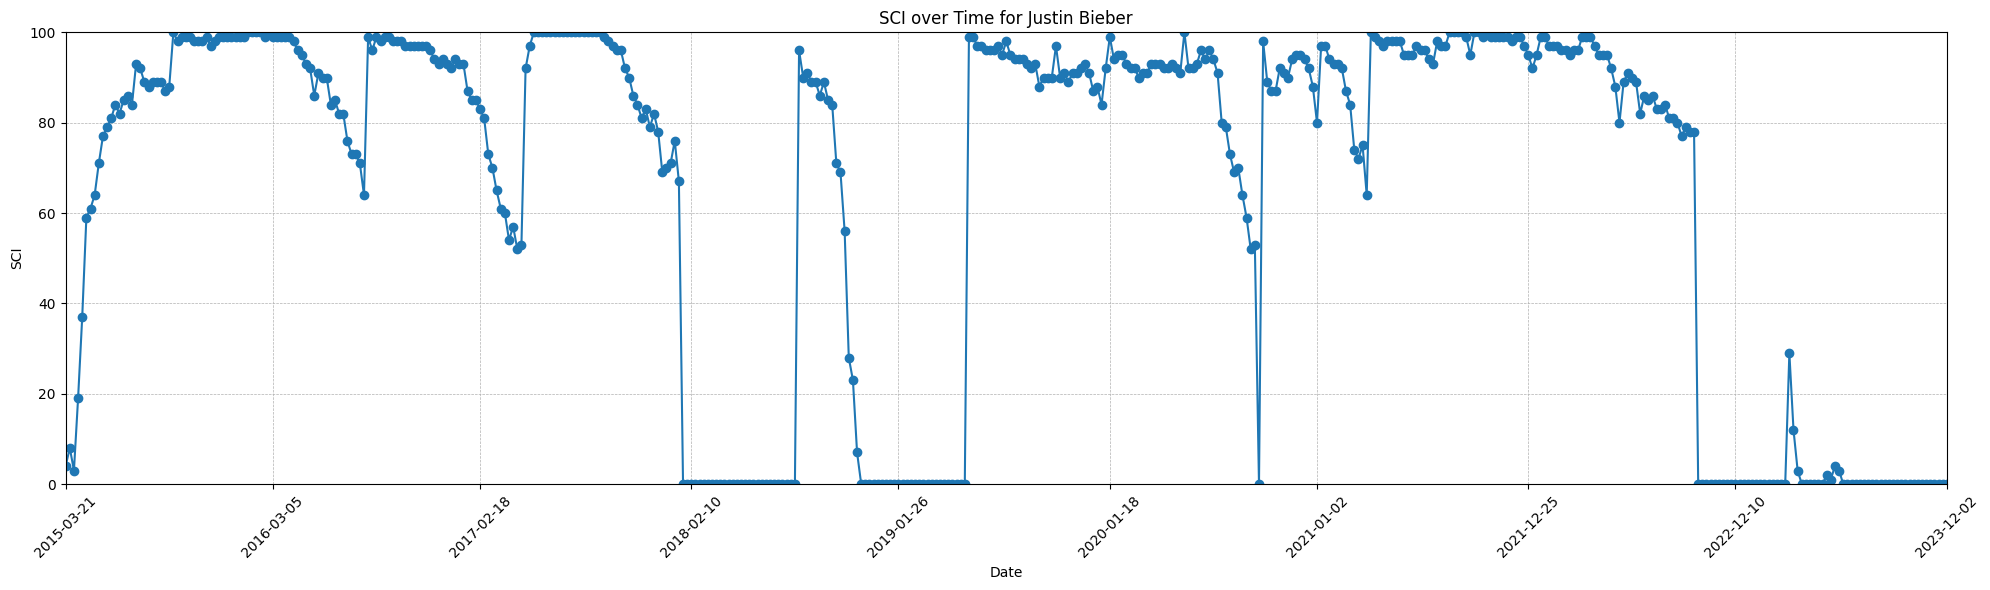

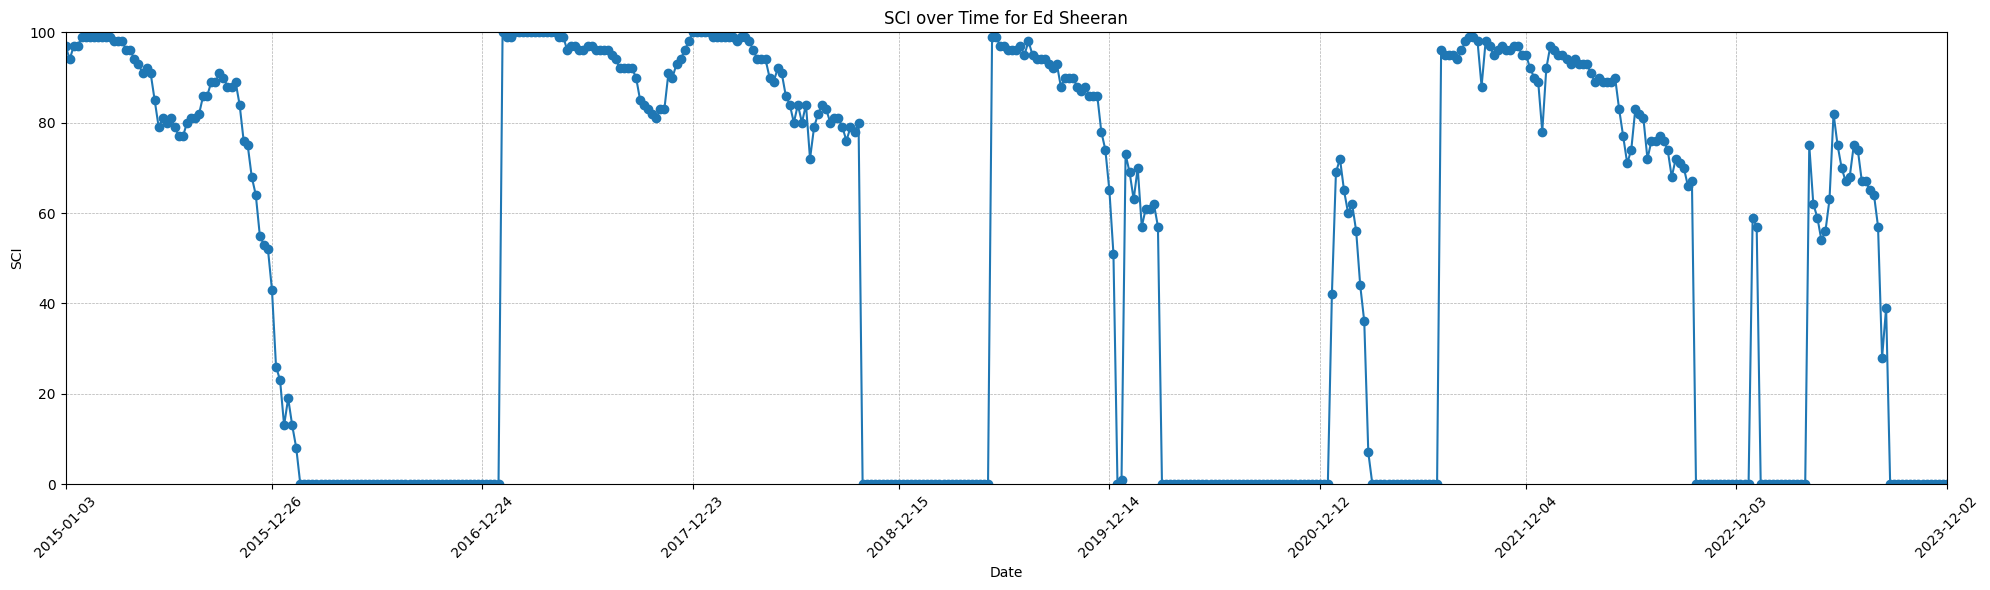

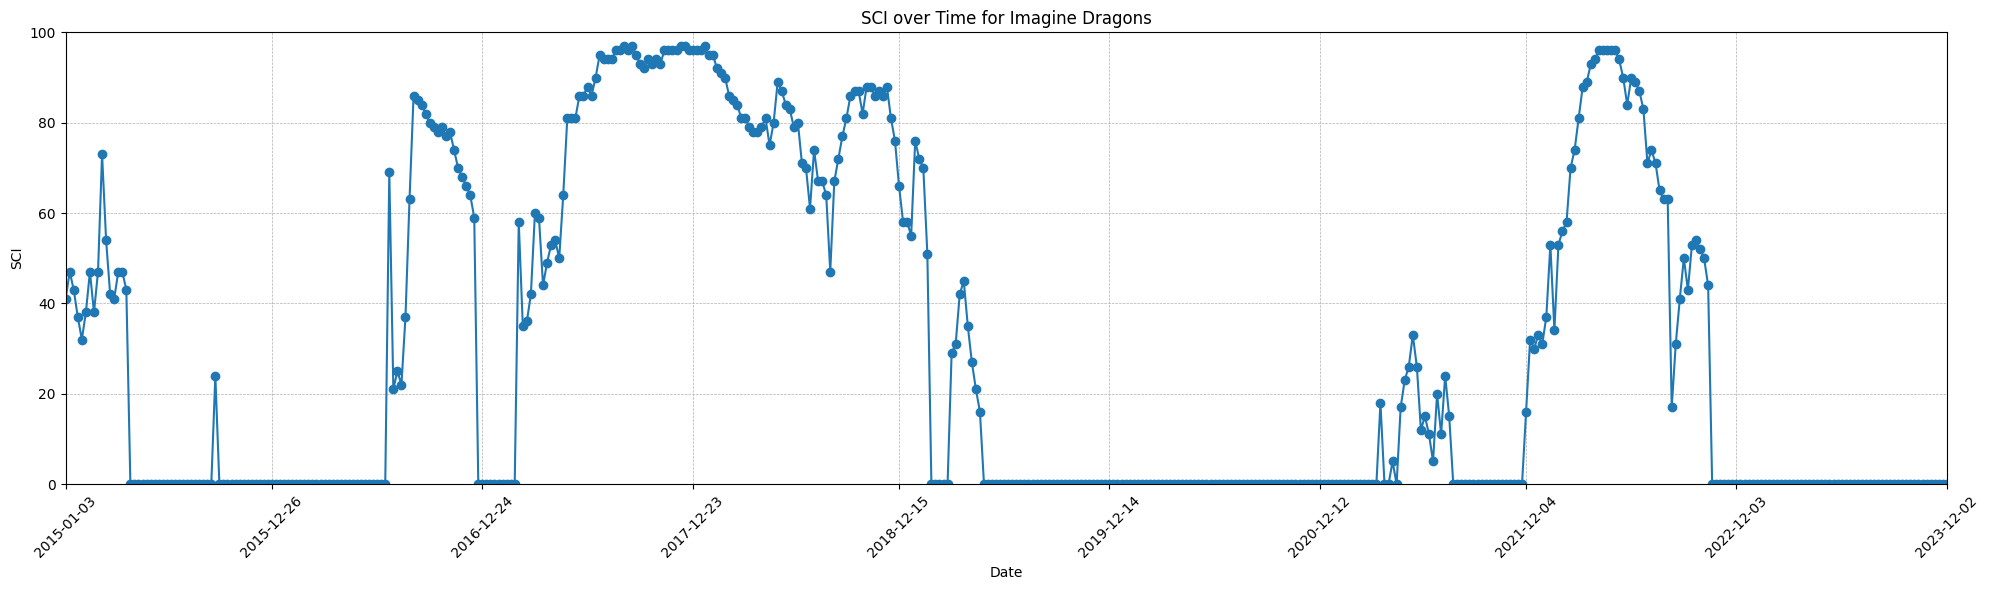

In [ ]:
# try year setup as 2015
SCI_chart_multi(df = df_ch_processed, artist_list = ["Justin Bieber", "Ed Sheeran", "Imagine Dragons"], year = 2015)

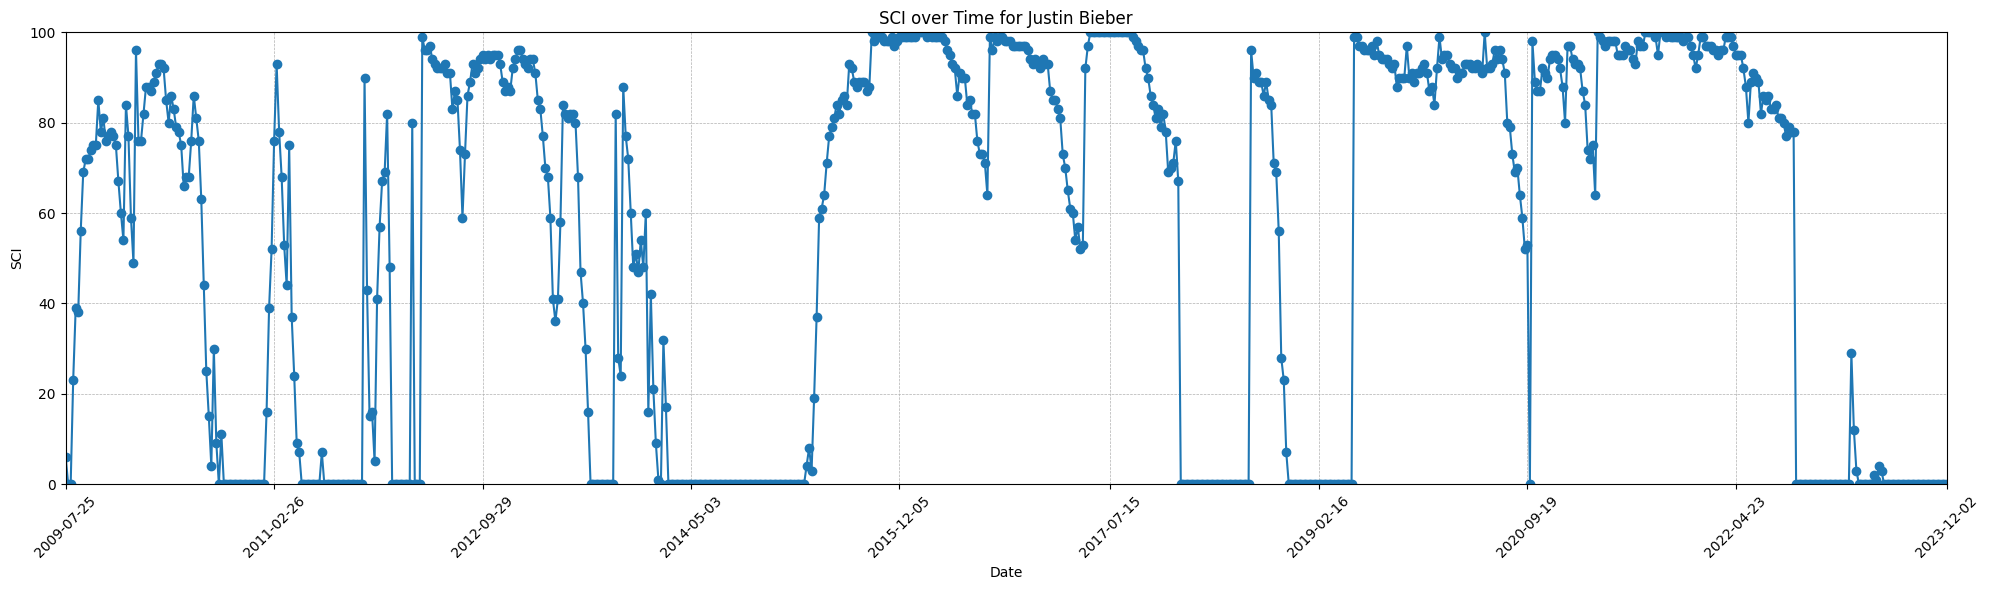

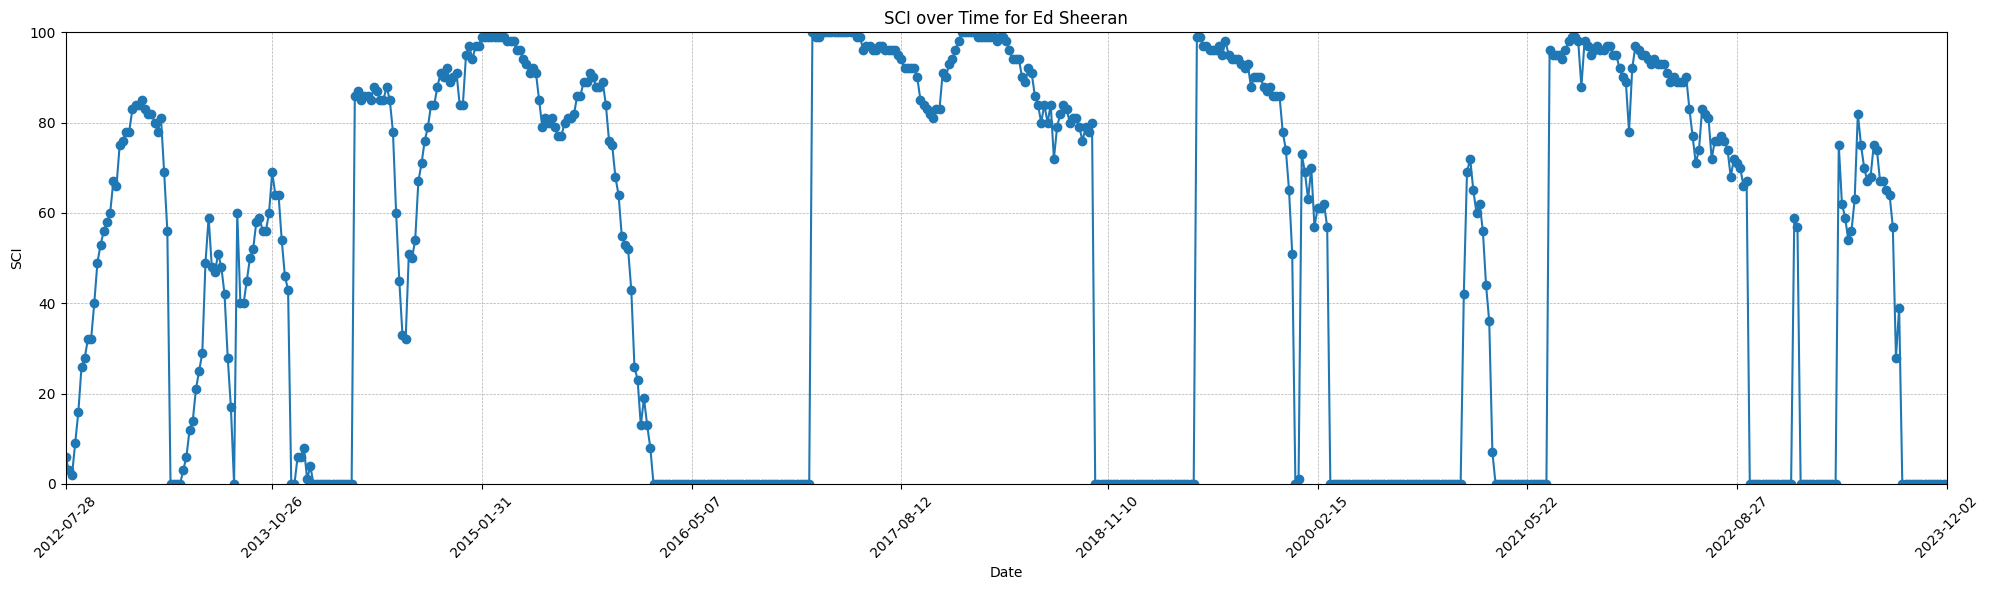

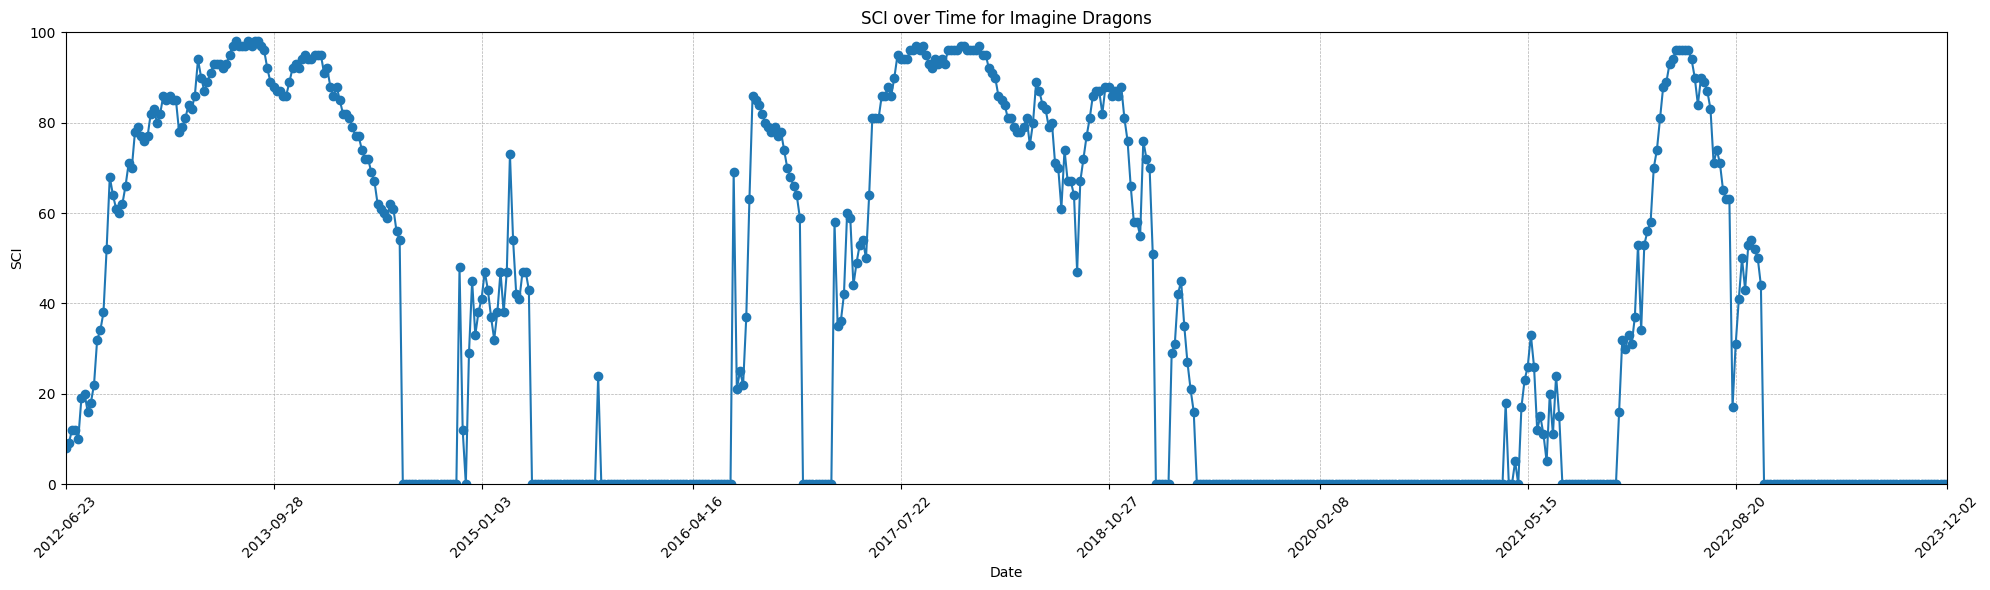

In [ ]:
# default value
SCI_chart_multi(df = df_ch_processed, artist_list = ["Justin Bieber", "Ed Sheeran", "Imagine Dragons"], year = None)

### 2.1.3 ACI(*Advanced* Collab Index) Chart

* The Chart(s) of f

> Indented block



In [ ]:
def chart_asi(df, artist_name, number_of_x_ticks=10, year=None):
    # Filter rows where the artist's name appears in the 'artist' column
    filtered_df = df[df['artist'].str.contains(artist_name)].copy()

    # Additional filter for when the artist's name is at the beginning (Lead Artist)
    lead_artist_df = df[df['artist'].str.startswith(artist_name)].copy()

    # Convert 'date' column to datetime format and optionally filter by year
    filtered_df['date'] = pd.to_datetime(filtered_df['date'])
    lead_artist_df['date'] = pd.to_datetime(lead_artist_df['date'])
    if year is not None:
        start_date = f'{year}-01-01'
        filtered_df = filtered_df[filtered_df['date'] >= pd.to_datetime(start_date)]
        lead_artist_df = lead_artist_df[lead_artist_df['date'] >= pd.to_datetime(start_date)]


    # Function to process dataframe to extract SCI
    def process_df(dataframe):
        # Group by date and get the row with the minimum rank for each date
        idx = dataframe.groupby('date')['rank'].idxmin()
        selected_rows = dataframe.loc[idx]

        # Make sure we have a row for every unique date in the original dataframe
        all_dates = df['date'].unique()
        selected_rows = selected_rows.set_index('date').reindex(all_dates).reset_index()

        # Compute the SCI column
        selected_rows['SCI'] = np.where(selected_rows['rank'].isna(), 0, 101 - selected_rows['rank'])

        # Format 'date' column to 'YYYY-MM-DD'
        selected_rows['date'] = pd.to_datetime(selected_rows['date']).dt.strftime('%Y-%m-%d')

        # Sort dataframe by date
        return selected_rows.sort_values(by='date', ascending=True).reset_index(drop=True)

    # Process both filtered dataframes
    df_sci = process_df(filtered_df)
    df_lead_sci = process_df(lead_artist_df)
    # Rename 'SCI' column to 'LeadArtistSCI' in the lead artist dataframe
    df_lead_sci.rename(columns={'SCI': 'LeadArtistSCI'}, inplace=True)

    # Merge both dataframes to have two separate columns for SCI and LeadArtistSCI
    merged_df = pd.merge(df_sci[['date', 'SCI']], df_lead_sci[['date', 'LeadArtistSCI']], on='date', how='left')

    # Find the first non-zero SCI for plotting
    first_non_zero_index = merged_df[(merged_df['SCI'] > 0) | (merged_df['LeadArtistSCI'] > 0)].index.min()
    df_filtered = merged_df.loc[first_non_zero_index:].copy()

    # Generate evenly spaced indices for the dates you want to show on the x-axis
    indices = np.linspace(start=0, stop=len(df_filtered) - 1, num=number_of_x_ticks, dtype=int)

    # Create a list of date labels using the indices
    date_labels = [df_filtered['date'].iloc[i] for i in indices]

    # Plotting the time series lines for the artist
    plt.figure(figsize=(14, 5))
    plt.plot(df_filtered['date'], df_filtered['SCI'], label='SCI')
    plt.plot(df_filtered['date'], df_filtered['LeadArtistSCI'], label='Lead Artist SCI', linestyle='--')
    plt.title(f"Advanced Collab Index for {artist_name}")
    plt.xlabel('Date')
    plt.ylabel('ACI')
    plt.xticks(ticks=df_filtered['date'].iloc[indices], labels=date_labels, rotation=45)
    plt.ylim(0, 100)  # Set y-axis from 0 to 100
    plt.xlim(df_filtered['date'].iloc[0], df_filtered['date'].iloc[-1])  # Set x-axis limits
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)  # Add a grid for better readability
    plt.tight_layout()  # Adjust subplot params for better layout
    plt.show()


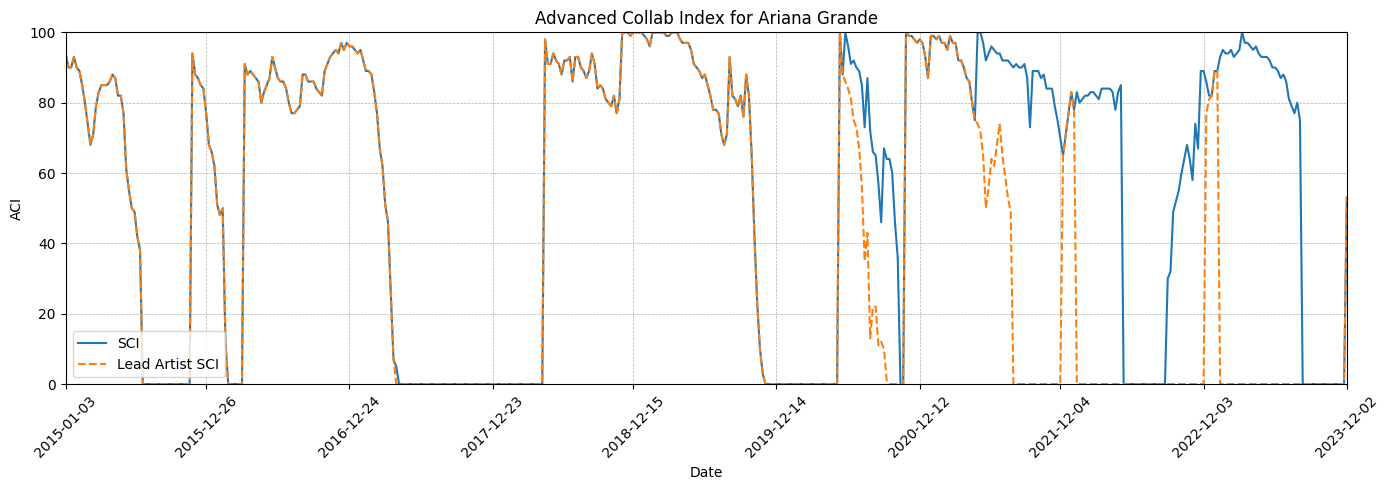

In [ ]:
# test the year = 2015 version
chart_asi(df= df_ch_processed, artist_name = 'Ariana Grande', number_of_x_ticks=10, year = 2015)

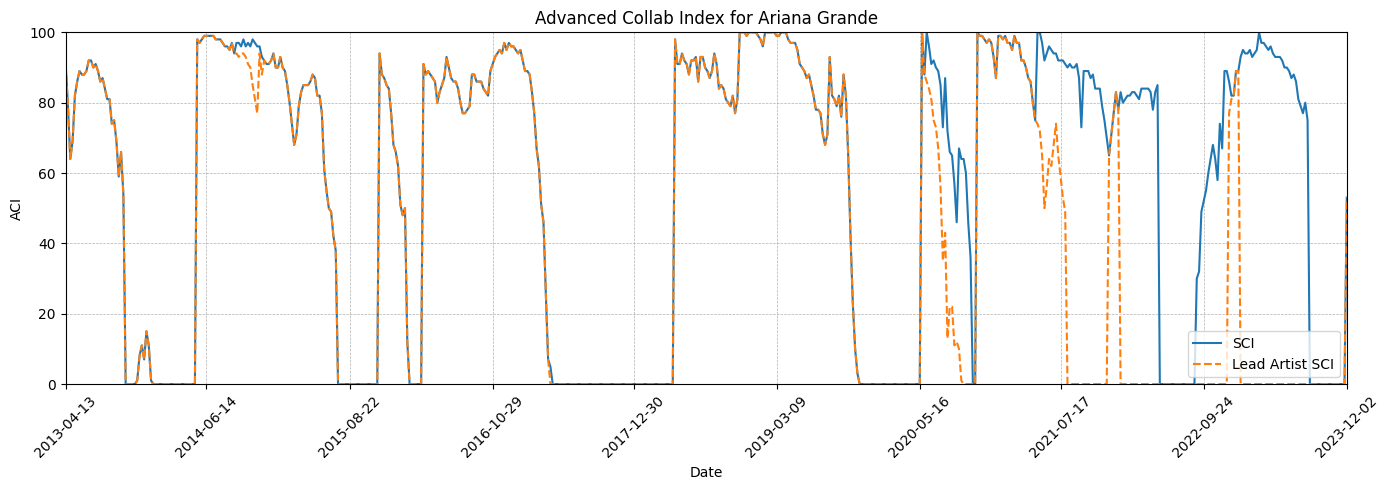

In [ ]:
chart_asi(df= df_ch_processed, artist_name = 'Ariana Grande', number_of_x_ticks=10)

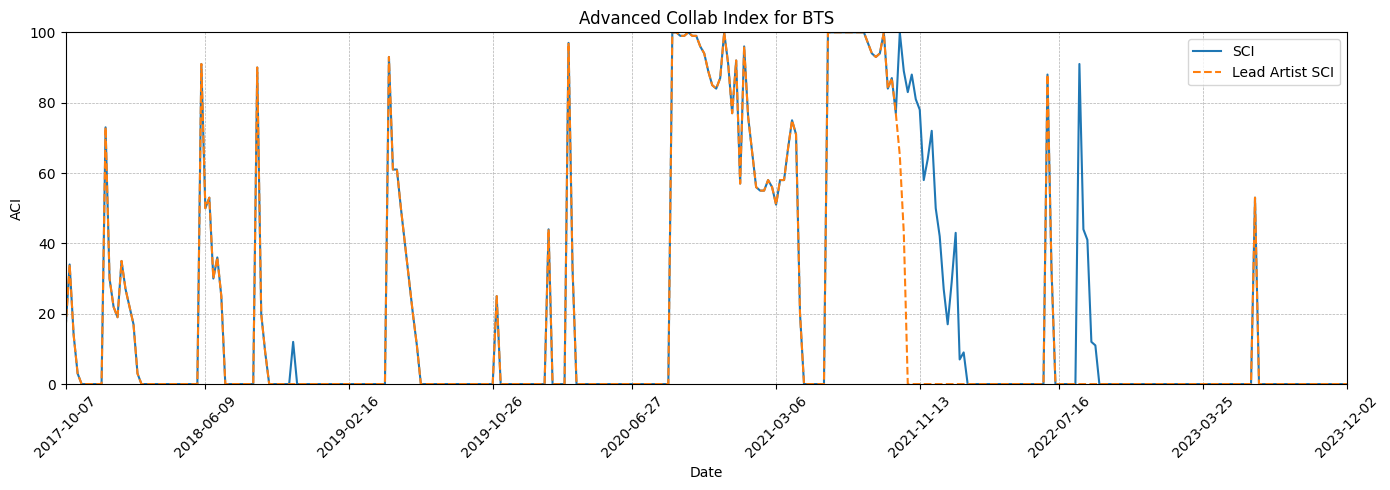

In [ ]:
chart_asi(df= df_ch_processed, artist_name = 'BTS', number_of_x_ticks=10)

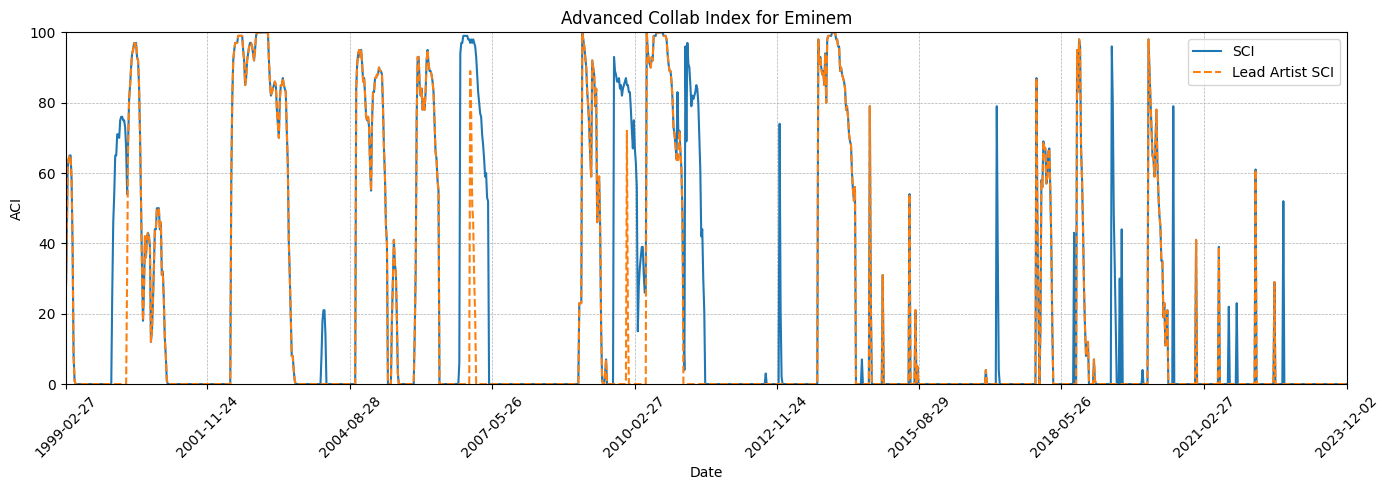

In [ ]:
chart_asi(df= df_ch_processed, artist_name = 'Eminem', number_of_x_ticks=10)

### 2.1.4 CCI(Complete Collab Index)

* Complete Collab Index including 3 lines of Album SCI, Lead Artist SCI and CCI together of a specific artist

In [ ]:
def complete_collab_index(df, df2, artist_name):
  """
  input = df: charts df, df2: album df, artist_name: artist name in string, number_of_x_tics: x ticks quantity in x axis
  output = merged df: df with SCI(SinmpleCollab Index), Leader SCI and Album SCI
  """

  filtered_df = df[df['artist'].str.contains(artist_name)]
  filtered_df2 = df2[df2['artist'].str.contains(artist_name)]
  filtered_df2 = filtered_df2.copy()
  filtered_df2.rename(columns = {'song':'album'}, inplace = True)

  # Additional filter for when the artist's name is at the beginning (Lead Artist)
  lead_artist_df = df[df['artist'].str.startswith(artist_name)]
  # Function to process dataframe to extract SCI
  def process_df(dataframe):
      # Group by date and get the row with the minimum rank for each date
      idx = dataframe.groupby('date')['rank'].idxmin()
      selected_rows = dataframe.loc[idx]

      # Make sure we have a row for every unique date in the original dataframe
      all_dates = df['date'].unique()
      selected_rows = selected_rows.set_index('date').reindex(all_dates).reset_index()

      # Compute the SCI column
      selected_rows['SCI'] = np.where(selected_rows['rank'].isna(), 0, 101 - selected_rows['rank'])

      # Sort dataframe by date
      return selected_rows.sort_values(by='date', ascending=True).reset_index(drop=True)

  # Process both filtered dataframes
  df_sci = process_df(filtered_df)
  df_lead_sci = process_df(lead_artist_df)
  df_album_sci = process_df(filtered_df2)
  # Rename 'SCI' column to 'LeadArtistSCI' in the lead artist dataframe
  df_lead_sci.rename(columns={'SCI': 'LeadArtistSCI'}, inplace=True)
  df_album_sci.rename(columns = {'SCI': 'AlbumSCI'}, inplace=True)

  # First merge df_sci and df_lead_sci
  merged_df = pd.merge(df_sci[['date', 'SCI']], df_lead_sci[['date', 'LeadArtistSCI']], on='date', how='left')

  # Then merge the result with df_album_sci
  merged_df = pd.merge(merged_df, df_album_sci[['date', 'AlbumSCI']], on='date', how='left')

  return merged_df

In [ ]:
complete_collab_index(df = df_al_processed, df2 = df_ch_processed, artist_name = 'Justin Bieber')
# get_mean_feature_ci(artist_name = 'Ed Sheeran', data_ac = df_ac, data_ch = df_ch)

,date,SCI,LeadArtistSCI,AlbumSCI
0,1973-01-06,0.0,0.0,0.0
1,1973-01-13,0.0,0.0,0.0
2,1973-01-20,0.0,0.0,0.0
3,1973-01-27,0.0,0.0,0.0
4,1973-02-03,0.0,0.0,0.0
...,...,...,...,...
2652,2023-11-04,0.0,0.0,0.0
2653,2023-11-11,0.0,0.0,0.0
2654,2023-11-18,0.0,0.0,0.0
2655,2023-11-25,0.0,0.0,0.0


### 2.1.5 FCI(Full Collab Index) Chart

* Full Collab Index Chart includes 3 lines of Album SCI, Lead Artist SCI and CCI in one chart for a specific artist

In [ ]:
def chart_fci(df, df2, artist_name, number_of_x_ticks=10, year=None):
    filtered_df = df[df['artist'].str.contains(artist_name)].copy()
    filtered_df2 = df2[df2['artist'].str.contains(artist_name)].copy()
    filtered_df2.rename(columns={'song':'album'}, inplace=True)

    # Additional filter for when the artist's name is at the beginning (Lead Artist)
    lead_artist_df = df[df['artist'].str.startswith(artist_name)].copy()

    # Convert 'date' column to datetime format and optionally filter by year
    for dataframe in [filtered_df, filtered_df2, lead_artist_df]:
        dataframe['date'] = pd.to_datetime(dataframe['date'])
        if year is not None:
            start_date = f'{year}-01-01'
            dataframe.drop(dataframe[dataframe['date'] < pd.to_datetime(start_date)].index, inplace=True)

    # Function to process dataframe to extract SCI
    def process_df(dataframe):
        # Group by date and get the row with the minimum rank for each date
        idx = dataframe.groupby('date')['rank'].idxmin()
        selected_rows = dataframe.loc[idx]

        # Make sure we have a row for every unique date in the original dataframe
        all_dates = df['date'].unique()
        selected_rows = selected_rows.set_index('date').reindex(all_dates).reset_index()

        # Compute the SCI column
        selected_rows['SCI'] = np.where(selected_rows['rank'].isna(), 0, 101 - selected_rows['rank'])

        # Sort dataframe by date
        return selected_rows.sort_values(by='date', ascending=True).reset_index(drop=True)

    # Process the dataframes
    df_sci = process_df(filtered_df)
    df_lead_sci = process_df(lead_artist_df)
    df_album_sci = process_df(filtered_df2)

    # Rename 'SCI' column to 'LeadArtistSCI' in the lead artist dataframe
    df_lead_sci = df_lead_sci.copy()
    df_album_sci = df_album_sci.copy()
    df_lead_sci.rename(columns={'SCI': 'LeadArtistSCI'}, inplace=True)
    df_album_sci.rename(columns = {'SCI': 'AlbumSCI'}, inplace=True)

    # First merge df_sci and df_lead_sci
    merged_df = pd.merge(df_sci[['date', 'SCI']], df_lead_sci[['date', 'LeadArtistSCI']], on='date', how='left')

    # Then merge the result with df_album_sci
    merged_df = pd.merge(merged_df, df_album_sci[['date', 'AlbumSCI']], on='date', how='left')

    # Find the first non-zero SCI for plotting
    first_non_zero_index = merged_df[(merged_df['SCI'] > 0) | (merged_df['LeadArtistSCI'] > 0) | (merged_df['AlbumSCI'] > 0)].index.min()
    df_filtered = merged_df.loc[first_non_zero_index:].copy()

    # Generate evenly spaced indices for the dates you want to show on the x-axis
    indices = np.linspace(start=0, stop=len(df_filtered) - 1, num=number_of_x_ticks, dtype=int)

    # Create a list of date labels using the indices
    # date_labels = [df_filtered['date'].iloc[i] for i in indices]
    # Create a list of date labels using the indices, formatted as 'YYYY-MM-DD'
    date_labels = [df_filtered['date'].iloc[i].strftime('%Y-%m-%d') for i in indices]

    # Plotting the time series lines for the artist
    plt.figure(figsize=(14, 5))
    plt.plot(df_filtered['date'], df_filtered['SCI'], label='SCI')
    plt.plot(df_filtered['date'], df_filtered['LeadArtistSCI'], label='Lead Artist SCI', linestyle='--')
    plt.plot(df_filtered['date'], df_filtered['AlbumSCI'], label='Album SCI', linestyle='-')
    plt.title(f"Full Collab Index for {artist_name}")
    plt.xlabel('Date')
    plt.ylabel('FCI')
    plt.xticks(ticks=df_filtered['date'].iloc[indices], labels=date_labels, rotation=45)
    plt.ylim(0, 100)  # Set y-axis from 0 to 100
    plt.xlim(df_filtered['date'].iloc[0], df_filtered['date'].iloc[-1])  # Set x-axis limits
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)  # Add a grid for better readability
    plt.tight_layout()  # Adjust subplot params for better layout
    plt.show()

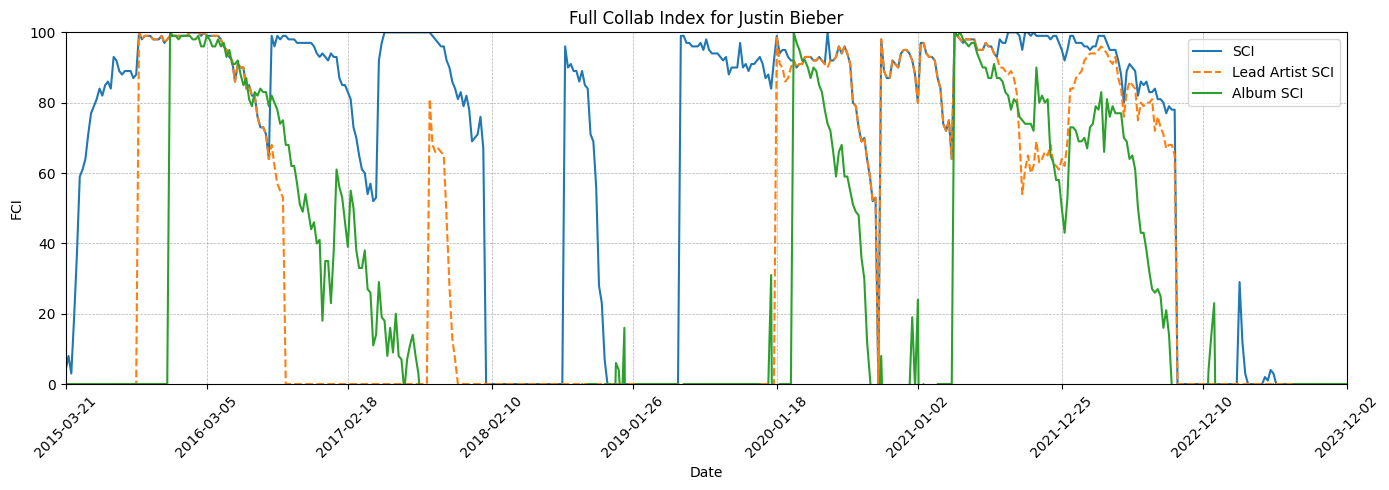

In [ ]:
# test the year = 2015 scenario
df = df_ch_processed
df2 = df_al_processed
artist_name = 'Justin Bieber'
chart_fci(df, df2, artist_name, number_of_x_ticks=10, year = 2015)

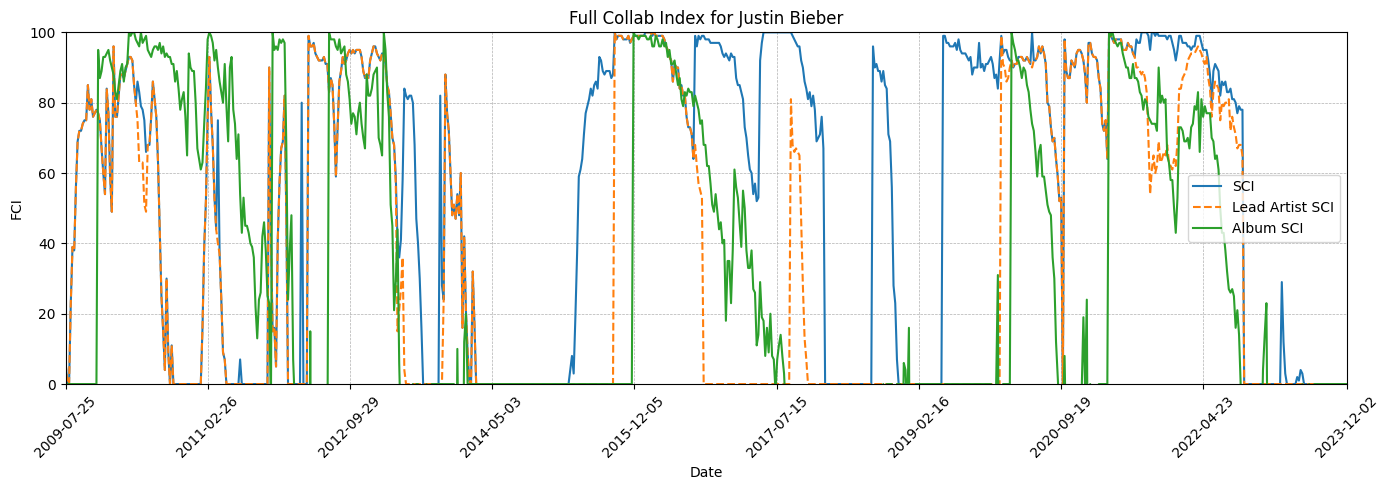

In [ ]:
df = df_ch_processed
df2 = df_al_processed
artist_name = 'Justin Bieber'
chart_fci(df, df2, artist_name, number_of_x_ticks=10)

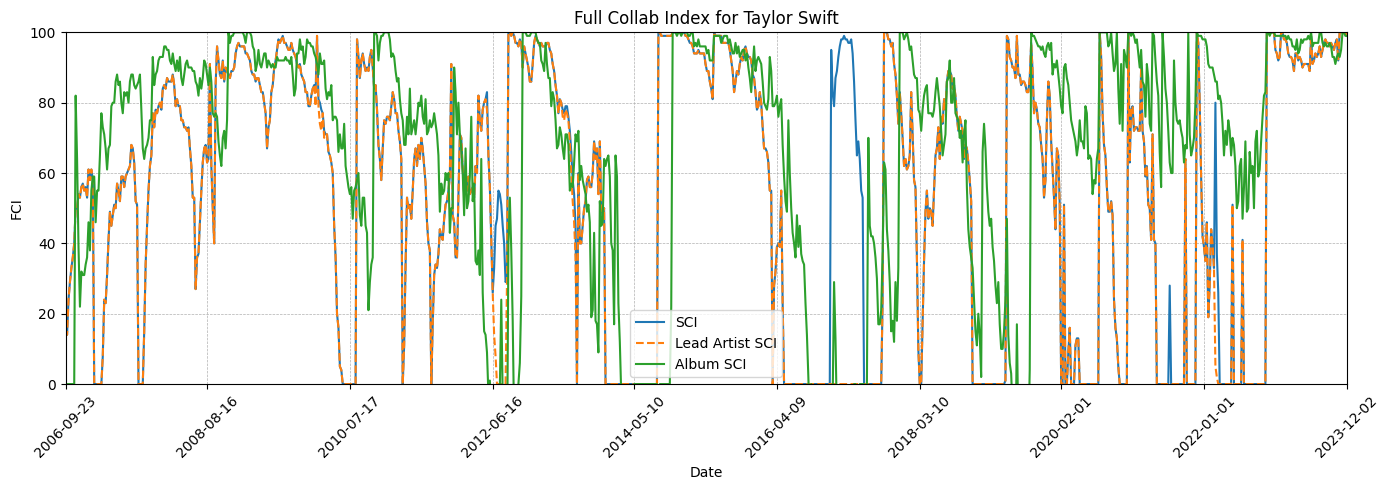

In [ ]:
df = df_ch_processed
df2 = df_al_processed
artist_name = 'Taylor Swift'
chart_fci(df, df2, artist_name, number_of_x_ticks=10)

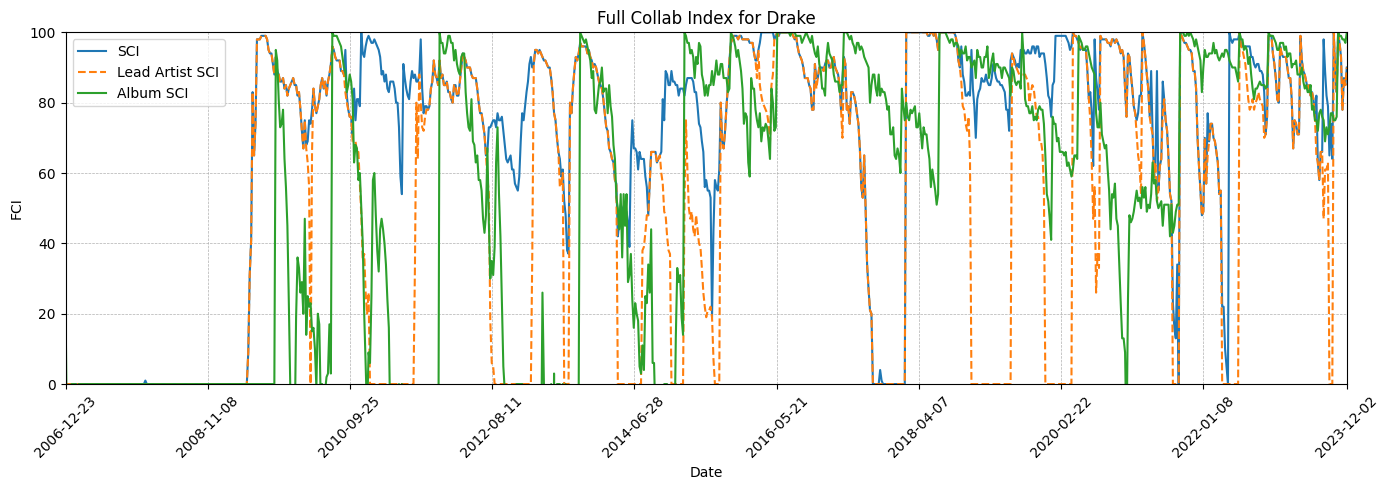

In [ ]:
df = df_ch_processed
df2 = df_al_processed
artist_name = 'Drake'
chart_fci(df, df2, artist_name, number_of_x_ticks=10)

### 2.1.6 AFI(Audio Features Index) Chart

* Audio Features Index includes 13 audio featuers to have an overview from our whole dataset

In [ ]:
def chart_afi(df_chart, color_chart, artist_name=None, year=None):
    # Create a copy of the dataframe
    df = df_chart.copy()

    # Filter based on year if provided
    if year is not None:
        df['date'] = pd.to_datetime(df['date'])
        df = df[df['date'].dt.year >= year]

    # Select relevant columns
    df = df[['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness',
             'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo',
             'time_signature', 'valence']]
    n_cols = 5
    n_rows = (df.shape[1] + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 3))

    # Get a colormap
    cmap = plt.get_cmap(color_chart)
    norm = mcolors.Normalize(vmin=0, vmax=df.shape[1])

    # Plotting data
    for i, (col, ax) in enumerate(zip(df.columns, axes.flatten())):
        # Choose a color from the colormap based on normalized value
        color = cmap(norm(i))

        if col == 'key':
            value_counts = df[col].value_counts().sort_index()
            ax.bar(x=value_counts.index, height=value_counts.values, alpha=0.7, color=color, edgecolor='black')
            ax.set_xticks(value_counts.index)
            ax.set_xticklabels(value_counts.index.astype(int))
        elif col == 'mode':
            value_counts = df[col].value_counts()
            ax.bar(x=value_counts.index, height=value_counts.values, alpha=0.7, color=color, edgecolor='black')
            ax.set_xticks([0, 1])
        else:
            ax.hist(df[col], bins=12, alpha=0.7, color=color, edgecolor='black')

        ax.set_title(col)
        ax.set_ylabel('Frequency')

    # Hide any unused axes
    for j in range(i+1, n_rows * n_cols):
        axes.flatten()[j].set_visible(False)

    # Set title
    title_font_size = 20
    year_text = "Starting from 1963" if year is None else f"Starting from {year}"
    if artist_name:
        title = f"Audio Features Index for {artist_name} ({year_text})"
    else:
        title = f"Full Dataset Audio Features Index ({year_text})"

    fig.suptitle(title, fontsize=title_font_size)

    plt.tight_layout()
    return plt.show()

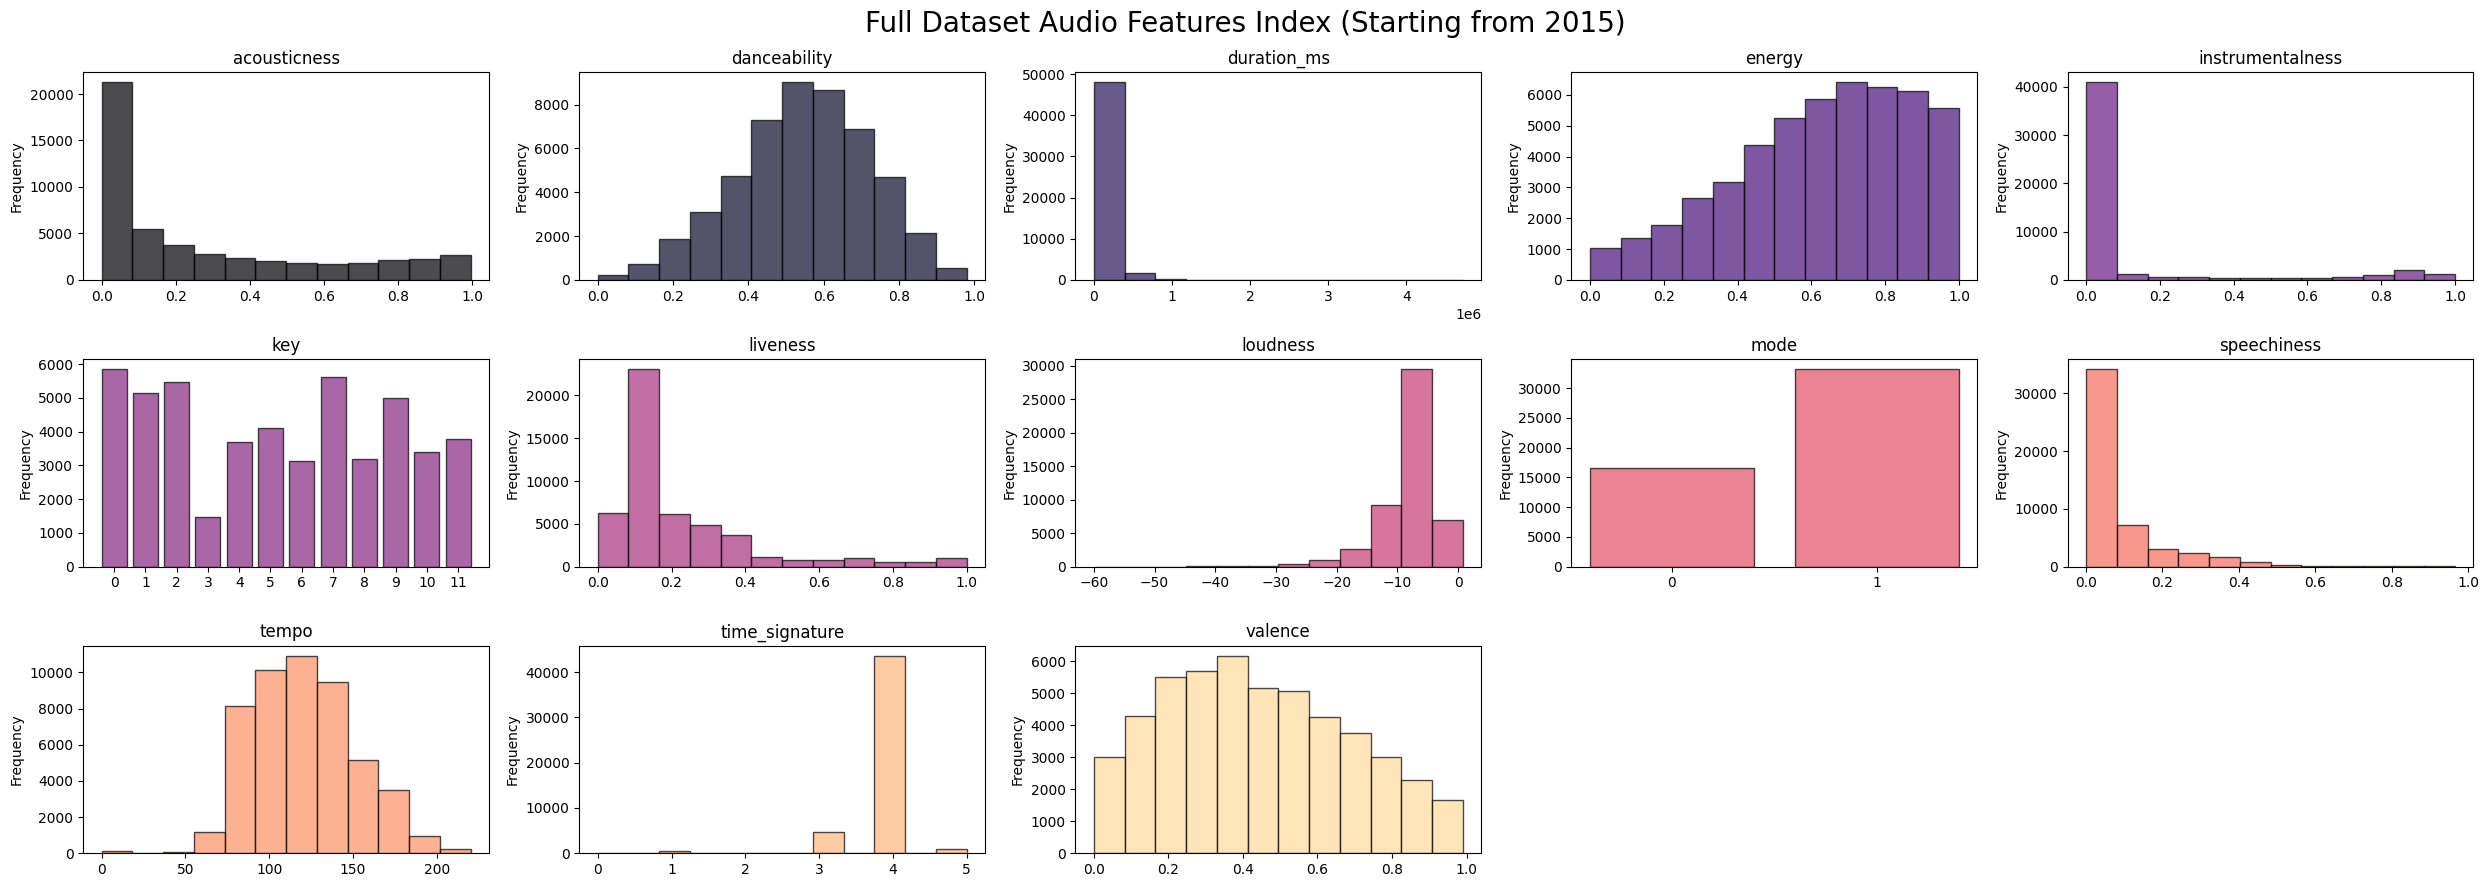

In [ ]:
# test if year = 2015
chart_afi(df_ac, 'magma', year = 2015)

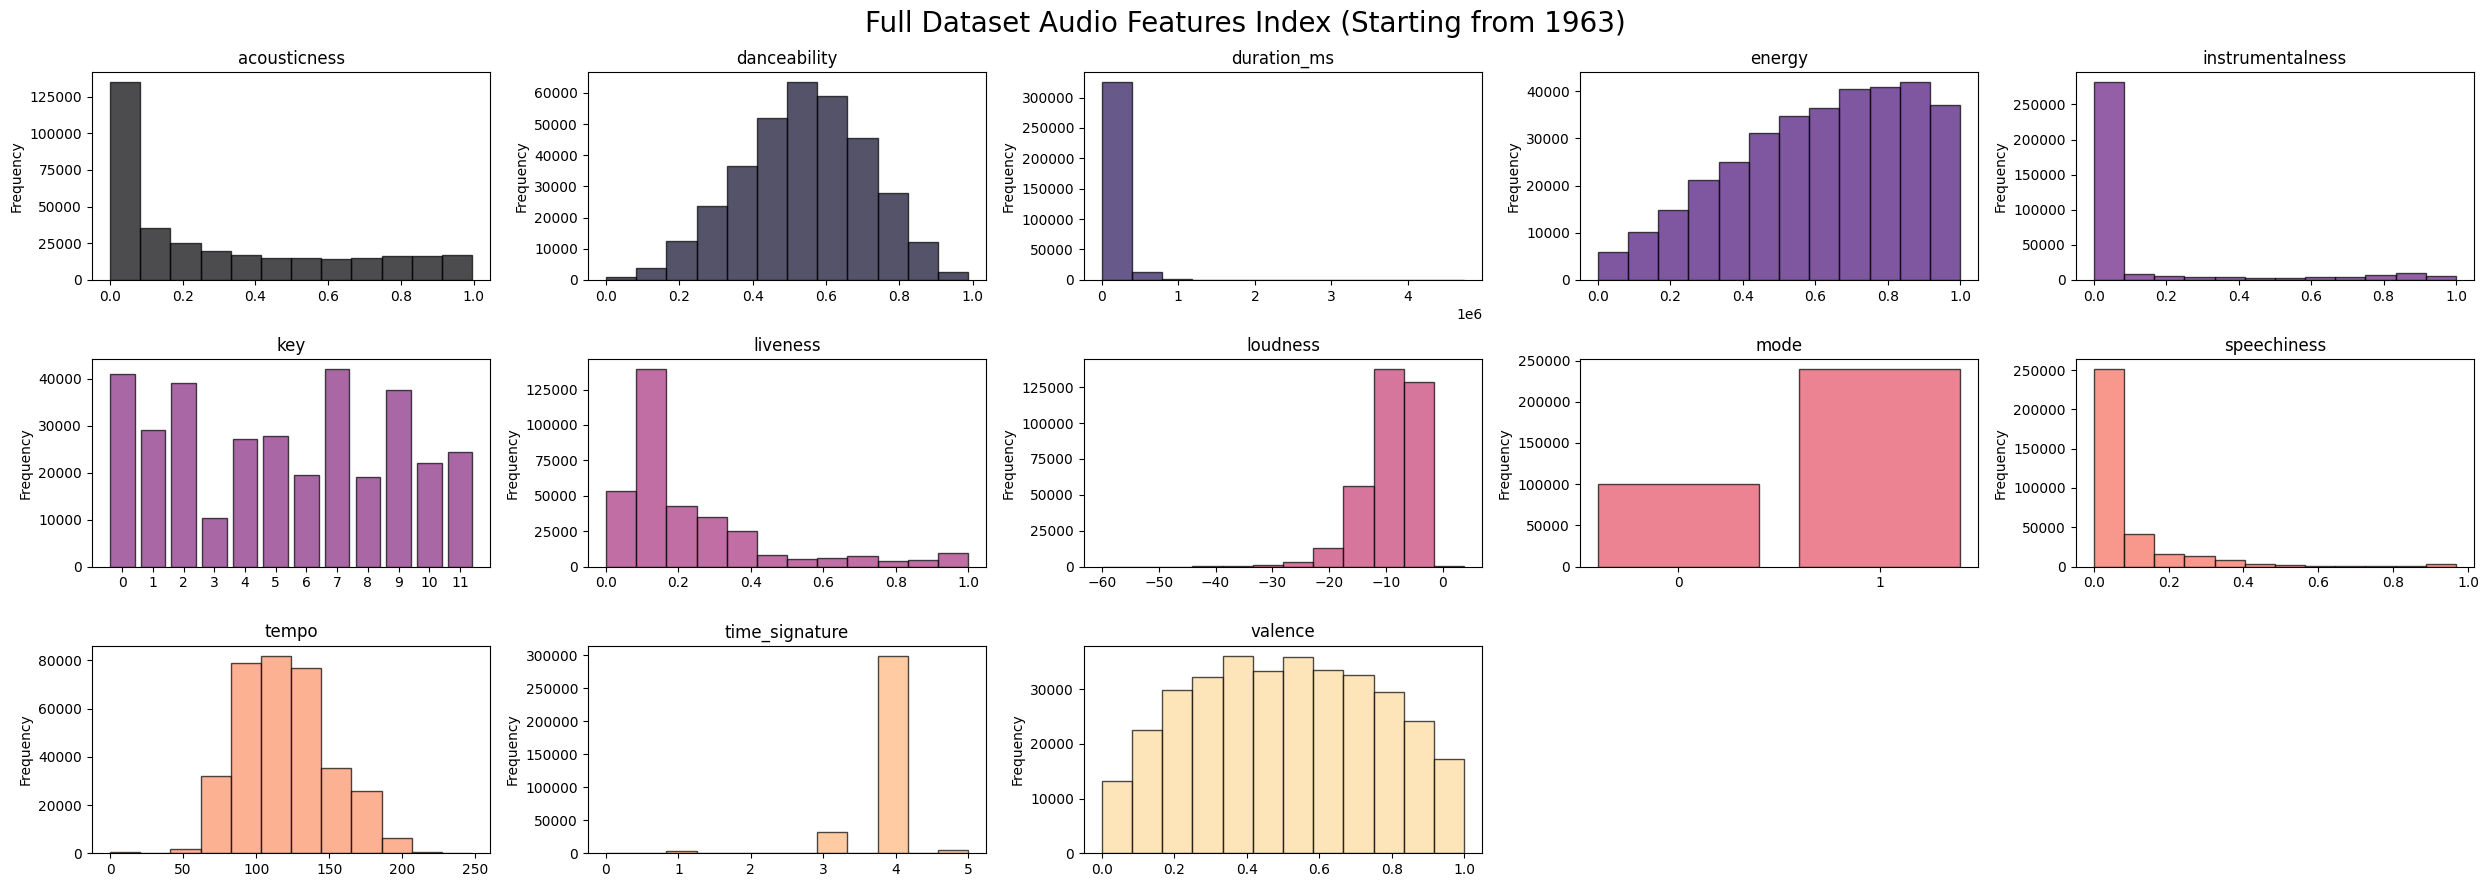

In [ ]:
# year = default
chart_afi(df_ac, 'magma')

### 2.1.7 AAFI(Artist Audio Features Index) Chart


* AAFI(Artist Audio Features Index) includes 10 audio featuers to have an overview for a specific Artist

In [ ]:
def chart_aafi(df, artist, color, year_start):
  df_artist = df[df['artist'].str.contains(artist, na=False)]
  return chart_afi(df_chart = df_artist, color_chart=color, artist_name = artist, year = year_start)


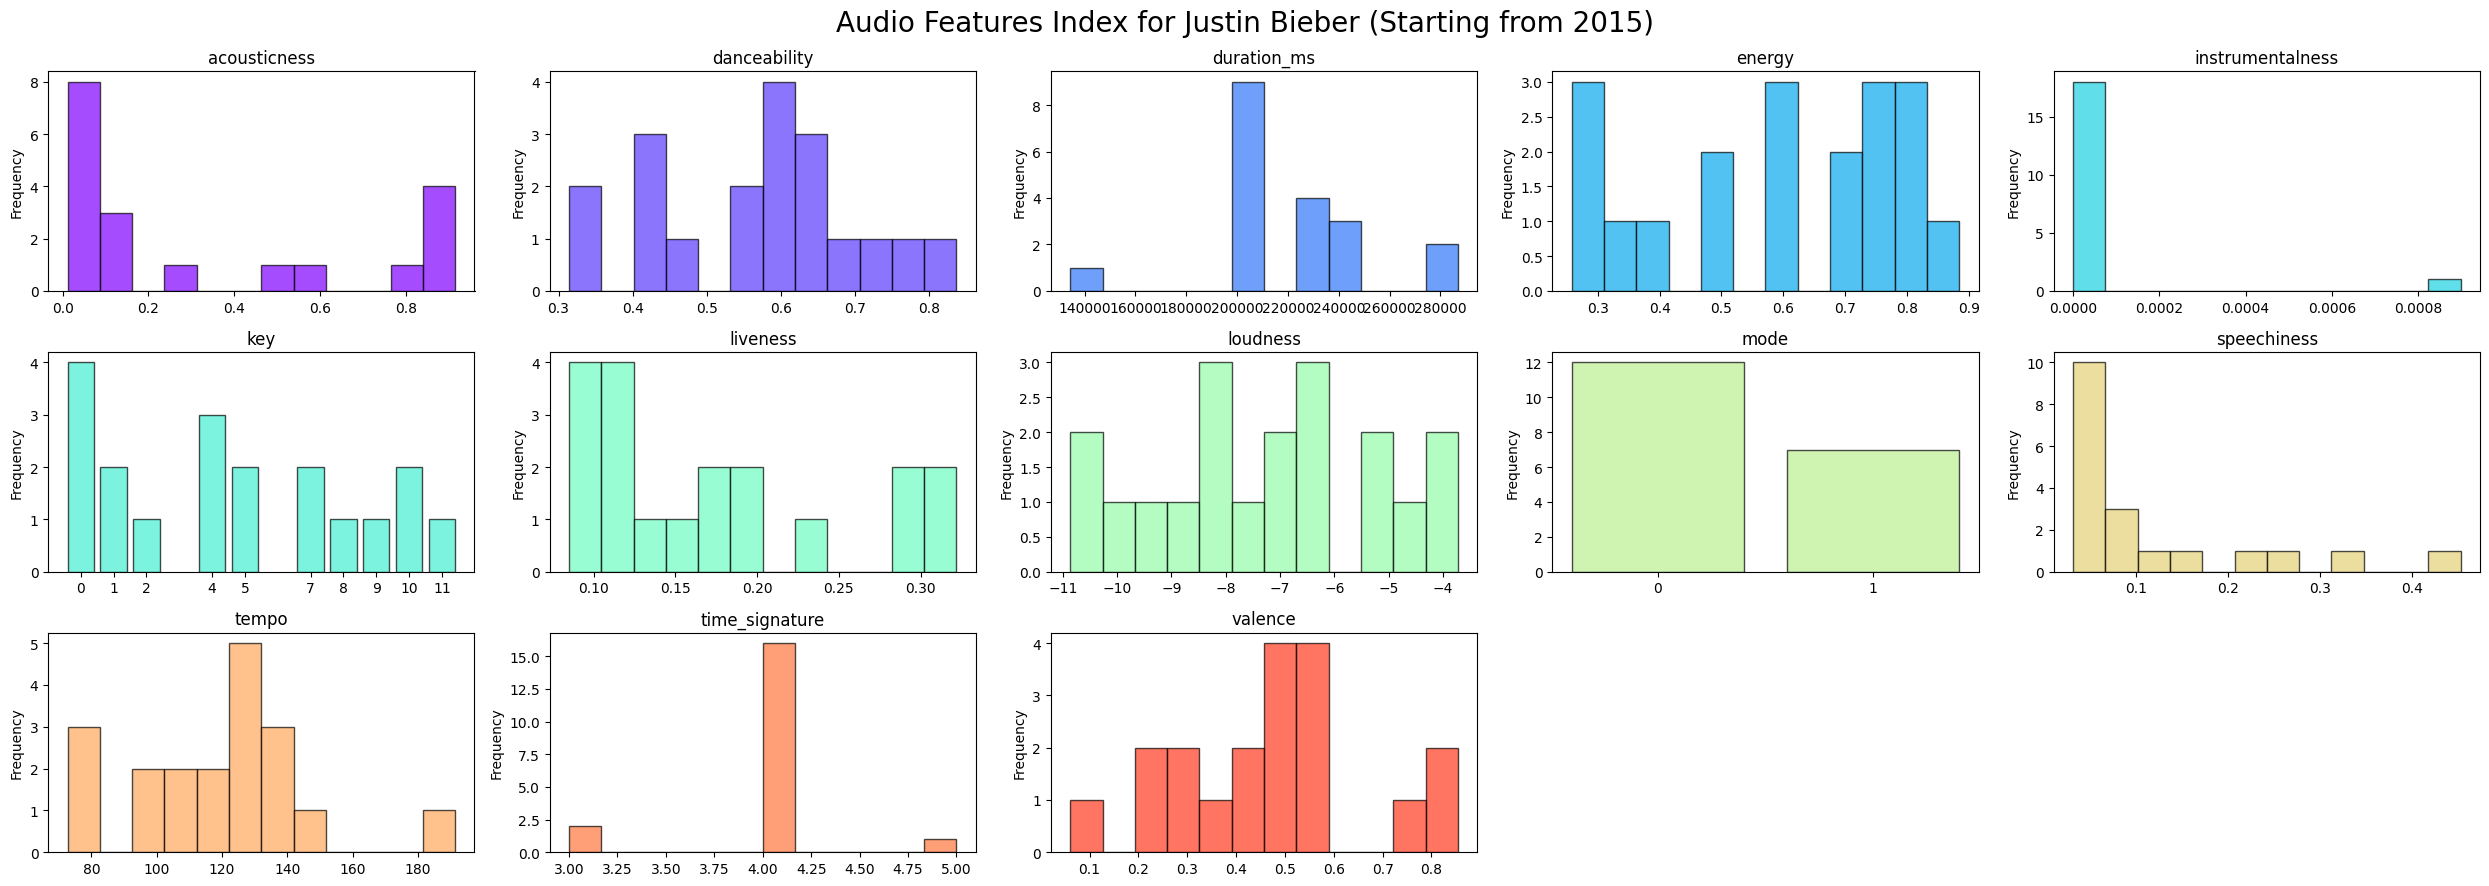

In [ ]:
# test year starting from 2015
chart_aafi(df = df_ac, artist = 'Justin Bieber', color = 'rainbow', year_start = 2015)

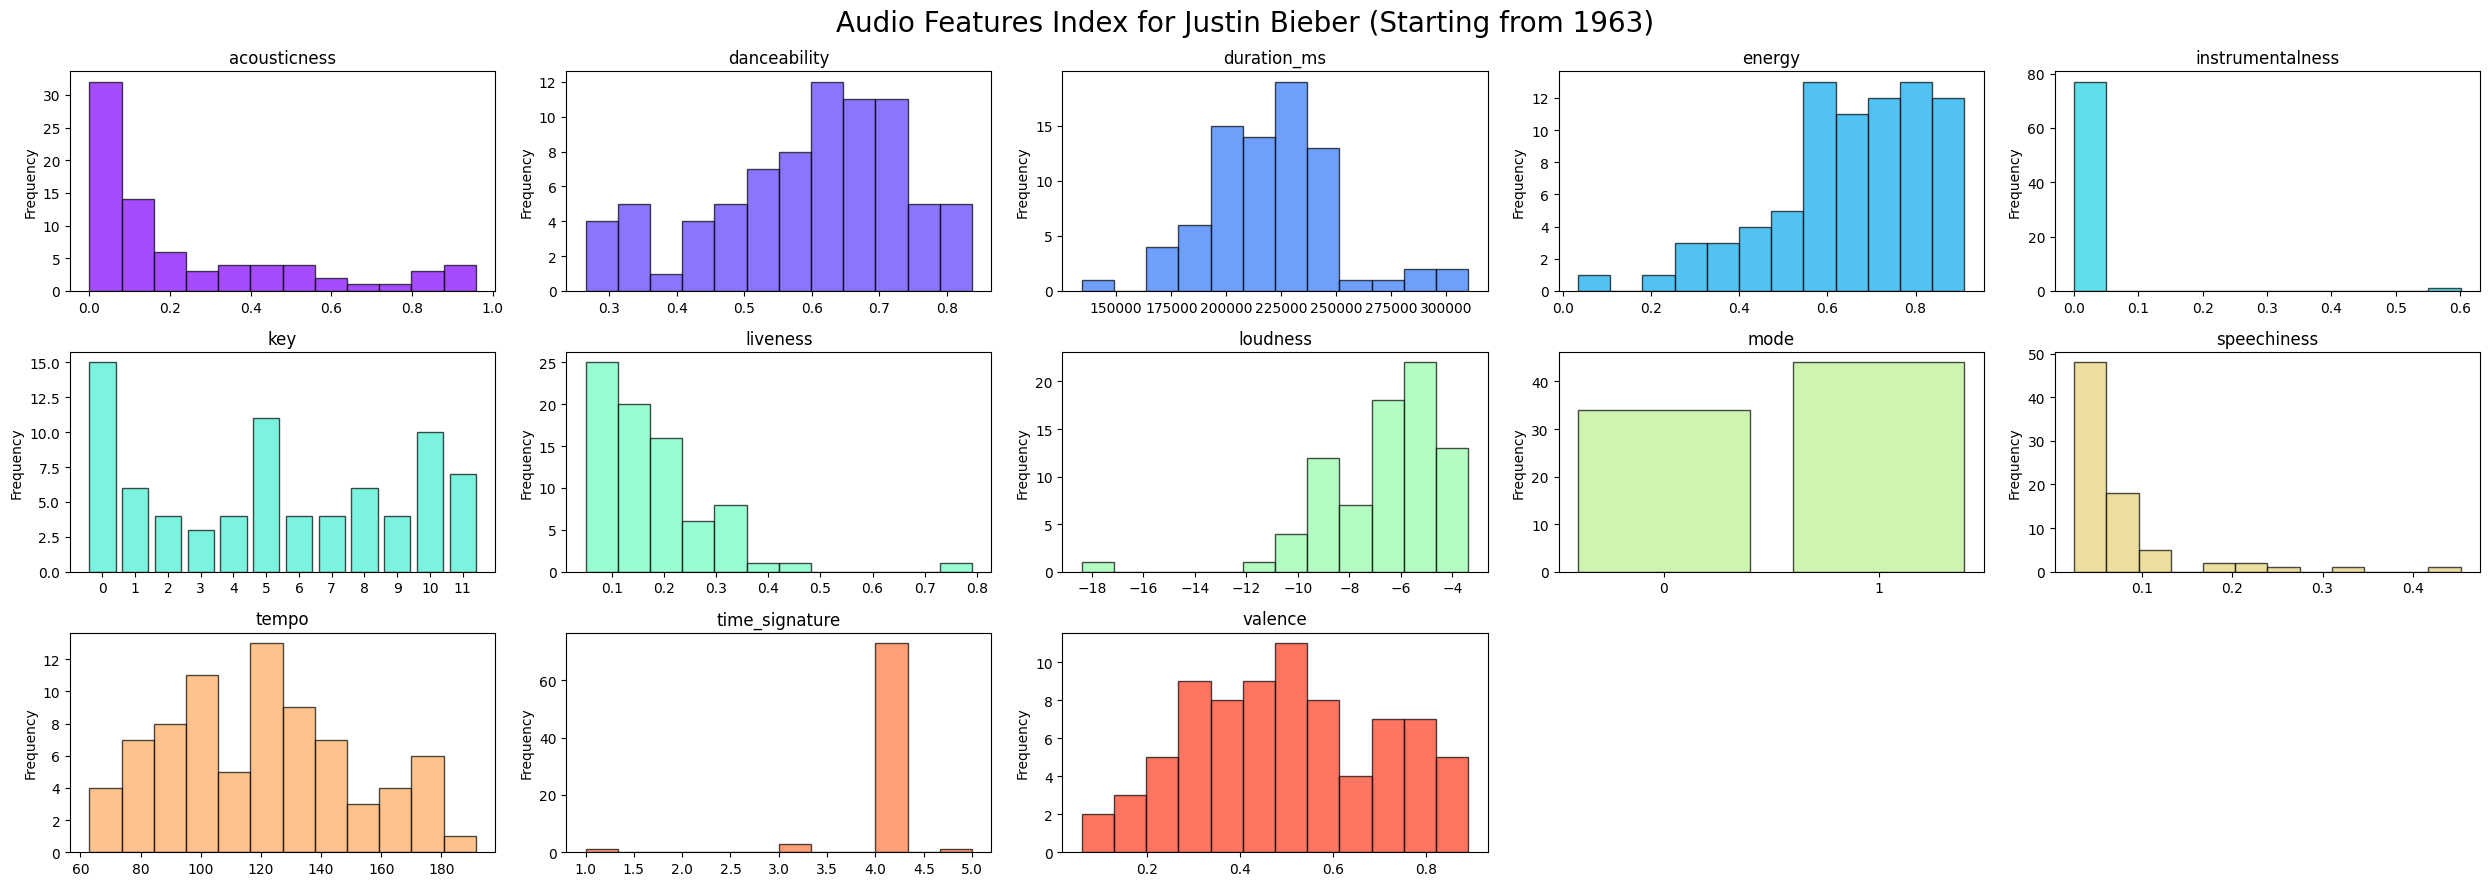

In [ ]:
# test year default, acdtually Justin Biber year starting from 2009
chart_aafi(df = df_ac, artist = 'Justin Bieber', color = 'rainbow', year_start=None)

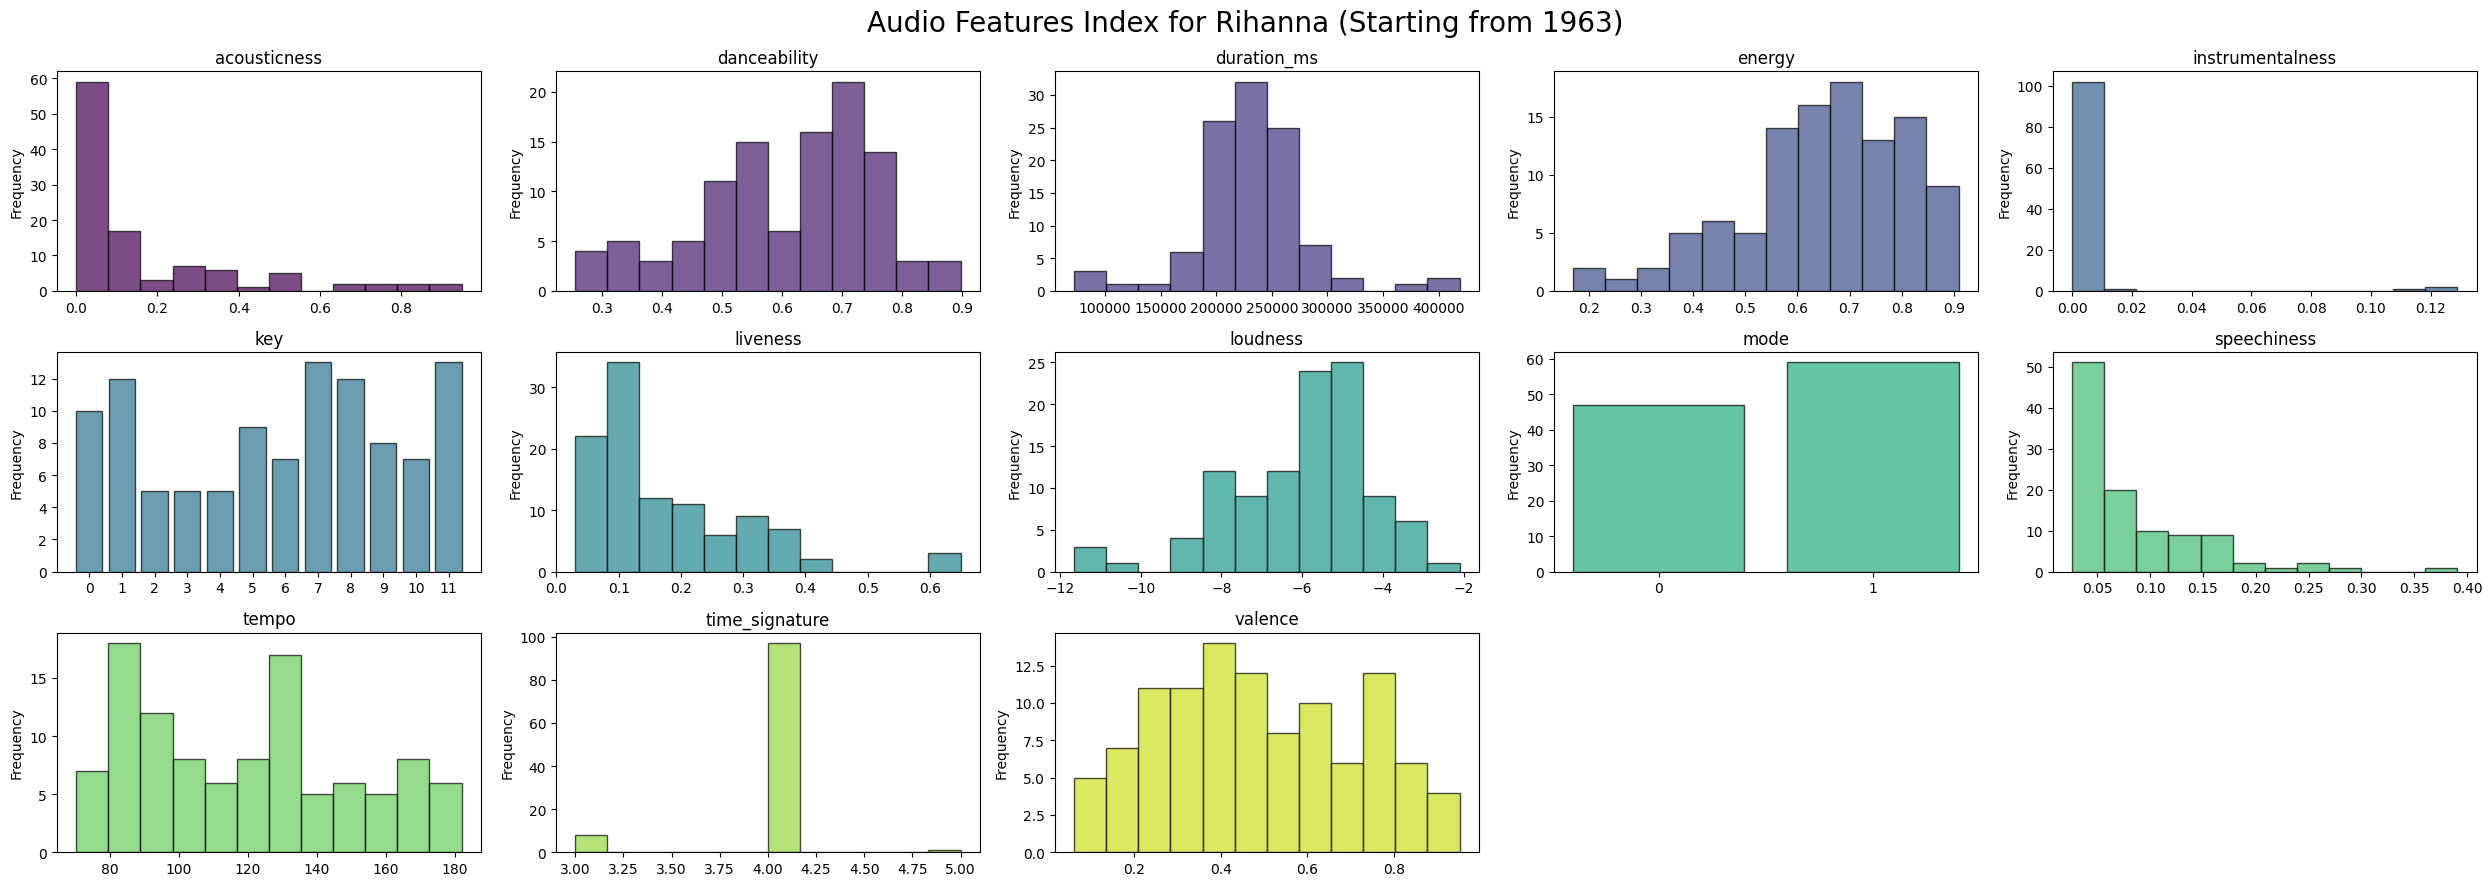

In [ ]:
chart_aafi(df = df_ac, artist = 'Rihanna', color = 'viridis', year_start=None)

### 2.1.8 CCI(Current Collab Index)

* Current Collab Index referes to a weighted index combing the consideration of the SCI, Leader Artist SCI and the Album SCI with weight back to 50 and 100 weeks to reflect the current popularity of collabortaion

In [ ]:
def current_collab_index(artist_name):
  """
  input - artist_name: string of artist name
  output - current collab index: an integer between 0 to 100
  """
  df = complete_collab_index(df_al_processed, df_ch_processed, artist_name)
  latest_100 = 0.75* max(df['SCI'].tail(100).max(),
                                df['LeadArtistSCI'].tail(100).max(),
                                df['AlbumSCI'].tail(100).max())
  latest_50 = max(df['SCI'].tail(50).max(),
                         df['LeadArtistSCI'].tail(50).max(),
                         df['AlbumSCI'].tail(50).max()).astype(int)
  current_collab_index = max(latest_100, latest_50)
  return current_collab_index

In [ ]:
current_collab_index('Weeknd')

100

### 2.1.9 CCAFI(Current Collab & Audio Features Index)

In [ ]:
def get_streamlit_demo(artist_list):
    final_df = pd.DataFrame()
    for artist in artist_list:
        df_artist = get_mean_feature_ci(artist_name=artist)[['artist', 'collab_index', 'acousticness', 'danceability', 'duration_ms',
            'energy', 'instrumentalness', 'liveness', 'loudness',
            'speechiness', 'tempo', 'valence']]

        # Append df_artist to final_df
        final_df = pd.concat([final_df, df_artist], axis=0)

    return final_df


In [ ]:
artist_list = ['Weeknd', 'Ariana Grande', 'Taylor Swift', 'Drake', 'Ed Sheeran', 'BTS', 'Justin Bieber', 'Eminem', 'Travis Scott', 'Post Malone']
df_demo_streamlit = get_streamlit_demo(artist_list)

In [ ]:
df = df_demo_streamlit
filename= 'demo'
get_csv(filename, df)

In [ ]:
def get_mean_feature_ci(artist_name):
  """
  input = artist, the string of the artist name to be selected
  output = the single row df with artist name, 10 audio features and collaboration index
  """
  # Filter the DataFrame for the given artist
  # df = df_ac[df_ac['artist'].str.contains(artist_name, na=False)]
  df = df_ac[df_ac['artist'].str.contains(artist_name, na=False, regex=False)].copy()



    # Check if the DataFrame is empty
  if df.empty:
      print(f"DataFrame is empty for artist: {artist_name}")
      return pd.DataFrame()  # Return an empty DataFrame or handle appropriately
  # Selecting the relevant audio features
  audio_features = ['acousticness', 'danceability', 'duration_ms', 'energy',
                    'instrumentalness', 'liveness', 'loudness', 'mode',
                    'speechiness', 'tempo', 'time_signature', 'valence']

  # Calculate the means of the audio features
  means = df[audio_features].mean()
  mode_key = df['key'].mode()[0]

  # Create a single row DataFrame with artist name, audio features mean, and collaboration index
  df_final = pd.DataFrame([means])
  df_final['key'] = mode_key
  df_final['artist'] = artist_name
  df_final['collab_index'] = current_collab_index(artist_name)

  # df_final['collaboration_index'] = collaboration_index
  df_final = df_final[['artist','collab_index','acousticness', 'danceability', 'duration_ms', 'energy',
                    'instrumentalness', 'liveness', 'loudness', 'mode',
                    'speechiness', 'tempo', 'time_signature', 'valence', 'key']]

  return df_final

In [ ]:
get_mean_feature_ci('Ed Sheeran').columns

Index(['artist', 'collab_index', 'acousticness', 'danceability', 'duration_ms',
       'energy', 'instrumentalness', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence', 'key'],
      dtype='object')

In [ ]:
get_mean_feature_ci('Weeknd')

,artist,collab_index,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,mode,speechiness,tempo,time_signature,valence,key
0,Weeknd,100,0.303214,0.565295,285339.102564,0.59891,0.009341,0.203904,-7.595692,0.24359,0.081121,127.136038,3.948718,0.320328,1.0


In [ ]:
get_mean_feature_ci('Ariana Grande')

,artist,collab_index,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,mode,speechiness,tempo,time_signature,valence,key
0,Ariana Grande,100,0.234112,0.621079,203643.396825,0.582095,0.000021,0.182589,-6.187127,0.634921,0.077067,113.020349,3.952381,0.440619,1.0


### 2.1.10 PDAFI(Power-Law Distribution Audio Features Index)

* To compare 2 artist their power-law-distribution-oriented audio features (acousticness, instrumentalness, liveness, and speechiness) similarity between 0 to 100

In [ ]:
def calculate_similarity_log_scale(x1, x2, distribution):
    # Filter out non-positive values from the distribution
    filtered_distribution = [val for val in distribution if val > 0]

    # Check if x1 and x2 are positive
    if x1 <= 0 or x2 <= 0:
        raise ValueError("x1 and x2 must be positive numbers")

    # Calculate log values
    log_max = math.log(max(filtered_distribution))
    log_min = math.log(min(filtered_distribution))
    normalized_log_diff = abs(math.log(x1) - math.log(x2)) / (log_max - log_min)
    similarity_score = (1 - normalized_log_diff) * 100

    return similarity_score

In [ ]:
x1 = get_mean_feature_ci('Weeknd')['acousticness'][0]
x2 = get_mean_feature_ci('Ariana Grande')['acousticness'][0]
distribution = df_ac['acousticness']
calculate_similarity_log_scale(x1, x2, distribution)

98.12734040505208

In [ ]:
x1 = get_mean_feature_ci('Weeknd')['speechiness'][0]
x2 = get_mean_feature_ci('Ariana Grande')['speechiness'][0]
distribution = df_ac['speechiness']
calculate_similarity_log_scale(x1, x2, distribution)

98.65018178941396

### 2.1.11 NAFI(Normal-Distribution Audio Features Index)

* To compare 2 artist their normal-distribution-oriented audio features (danceability, duration_ms, energy, loudness, mode, tempo, time_signature, 'valence) similarity between 0 to 100

In [ ]:
def calculate_similarity_normal_distribution(x1, x2, distribution):
    mean = np.mean(distribution)
    std = np.std(distribution)

    z1 = (x1 - mean) / std
    z2 = (x2 - mean) / std

    normalized_diff = abs(z1 - z2) / 6
    similarity_score = (1 - normalized_diff) * 100

    return similarity_score

In [ ]:
x1 = get_mean_feature_ci('Weeknd')['energy'][0]
x2 = get_mean_feature_ci('Ariana Grande')['energy'][0]
distribution = df_ac['energy']
calculate_similarity_normal_distribution(x1, x2, distribution)

98.851635395032

In [ ]:
x1 = get_mean_feature_ci('Weeknd')['danceability'][0]
x2 = get_mean_feature_ci('Ariana Grande')['danceability'][0]
distribution = df_ac['danceability']
calculate_similarity_normal_distribution(x1, x2, distribution)

94.55721824249696

In [ ]:
x1 = get_mean_feature_ci('Weeknd')['tempo'][0]
x2 = get_mean_feature_ci('Ariana Grande')['tempo'][0]
distribution = df_ac['tempo']
calculate_similarity_normal_distribution(x1, x2, distribution)

92.25625823313305

In [ ]:
x1 = get_mean_feature_ci('Weeknd')['valence'][0]
x2 = get_mean_feature_ci('Ariana Grande')['valence'][0]
distribution = df_ac['valence']
calculate_similarity_normal_distribution(x1, x2, distribution)

92.0817219756072

In [ ]:
x1 = get_mean_feature_ci('Weeknd')['time_signature'][0]
x2 = get_mean_feature_ci('Ariana Grande')['time_signature'][0]
distribution = df_ac['time_signature']
calculate_similarity_normal_distribution(x1, x2, distribution)

99.86543133338118

### 2.1.12 RAFI(Radar Audio Features Index)

In [ ]:
def RAFI(artist1, artist2):
  df = df_ac
  pd_features = ['acousticness', 'instrumentalness', 'liveness','speechiness']
  features = ['acousticness', 'danceability','duration_ms', 'energy', 'instrumentalness','liveness',
       'loudness', 'speechiness', 'tempo', 'valence']
  array_feature = []
  for feature in features:
    x1 = get_mean_feature_ci(artist1)[feature][0]
    x2 = get_mean_feature_ci(artist2)[feature][0]
    distribution = df[feature]

    if feature in pd_features:
      array_element = calculate_similarity_log_scale(x1, x2, distribution)
    else:
      array_element = calculate_similarity_normal_distribution(x1, x2, distribution)
    array_feature.append(array_element)
  return array_feature, sum(array_feature) / len(array_feature)

In [ ]:
RAFI(artist1 = 'Weeknd', artist2='Ariana Grande')

([98.12734040505208,
  94.55721824249696,
  86.68439100029694,
  98.851635395032,
  55.95236931347522,
  97.66608231856509,
  94.89763928797016,
  98.65018178941396,
  92.25625823313305,
  92.0817219756072],
 90.97248379610429)

### 2.1.13 RAFIC(Radar Audio Features Index Chart)

In [ ]:
def get_radar(artist1, artist2, color_chart):
  # Define the number of variables you want to plot.
  num_vars = 10

  # Create an array for a single entity.
  values = np.array(RAFI(artist1, artist2)[0])

  # Compute angle for each axis
  angles = np.linspace(0, 2 * pi, num_vars, endpoint=False).tolist()

  # The plot is circular, so we need to "complete the loop" and append the start to the end.
  values = np.concatenate((values, [values[0]]))
  angles += angles[:1]

  # Initialize the spider plot
  fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

  # Draw one axe per variable and add labels
  labels = ['acousticness', 'danceability','duration_ms', 'energy', 'instrumentalness','liveness',
       'loudness', 'speechiness', 'tempo', 'valence']
  ax.set_theta_offset(pi / 2)
  ax.set_theta_direction(-1)

  plt.xticks(angles[:-1], labels)

  # Draw ylabels
  ax.set_rscale('linear')
  plt.yticks([20, 40, 60, 80, 100], ["20", "40", "60", "80", "100"], color="grey", size=12)
  plt.ylim(0, 100)

  # Plot data
  ax.plot(angles, values, color= color_chart, linewidth=2, linestyle='solid')
  ax.fill(angles, values, color= color_chart, alpha=0.4)

  plt.title(f"Radar Chart of Audio Features Index for {artist1} , {artist2}", fontsize= 16)
  print(f"The Overall Collab Index between {artist1} and {artist2} is {round(RAFI(artist1, artist2)[1],2)}")
  # Show the plot
  return plt.show()


The Overall Collab Index between Weeknd and Ariana Grande is 90.97


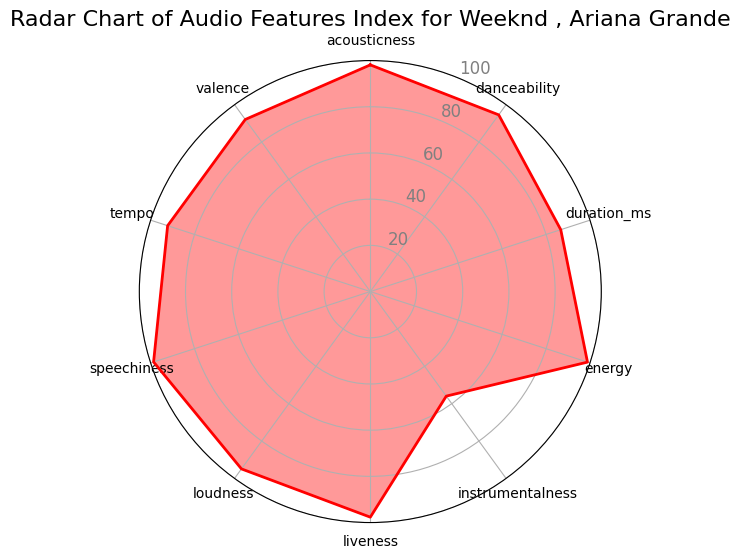

In [ ]:
get_radar(artist1 = 'Weeknd', artist2='Ariana Grande', color_chart = 'red')

The Overall Collab Index between Kenny G and Cardi B is 79.42


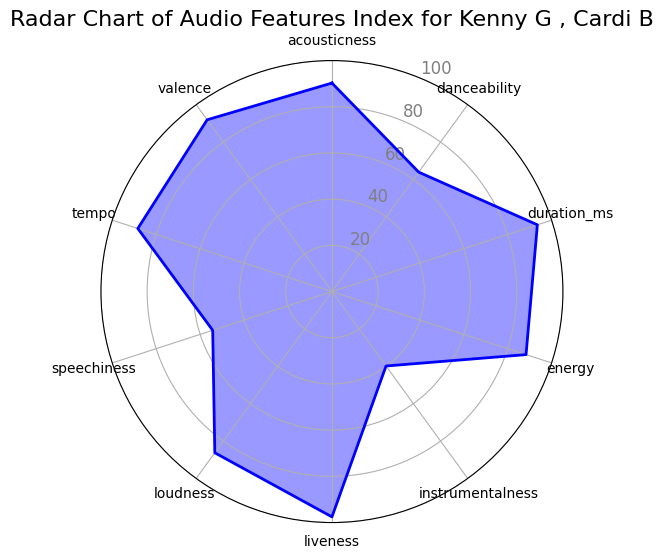

In [ ]:
get_radar(artist1 = 'Kenny G', artist2='Cardi B', color_chart = 'blue')

The Overall Collab Index between Norah Jones and Eminem is 80.61


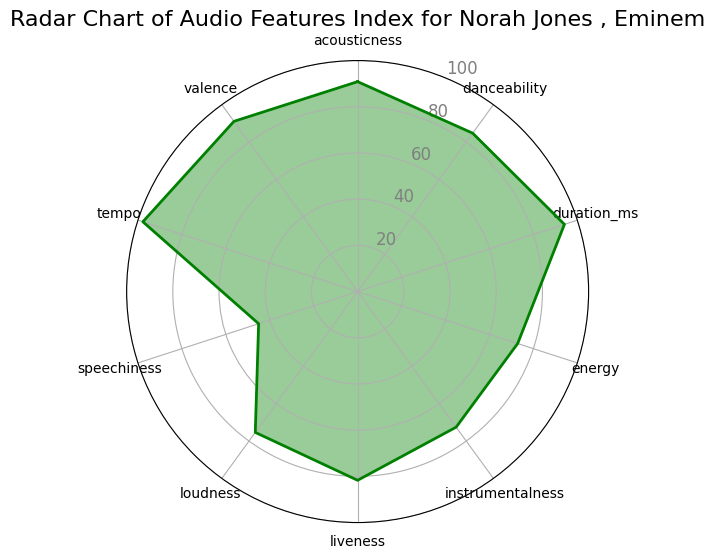

In [ ]:
get_radar(artist1 = 'Norah Jones', artist2='Eminem', color_chart = 'green')